In [18]:
import xarray as xr
import numpy as np
import glob2 as glob
import functions
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

In [44]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'

SM_ERA5 = xr.open_dataset(rpath+'soil_moisture_ERA5/data_stream-moda.nc')
SM_ERA5_1994_2025 = SM_ERA5.sel(valid_time=slice('1994-01-01','2025-09-01'))
SM_ERA5_1994_2025.to_netcdf(rpath+'SM_ERA5_1994_2025.nc')

In [ ]:
filepath='/nird/datalake/NS9560K/diagnostics/ILAMB-Data/DATA/mrsos/WangMao/mrsos_olc.nc'

SM_WM = xr.open_dataset(filepath)
SM_WM_1994_2016 = SM_WM.sel(time=slice('1994-01-01','2016-12-31'),lat=slice(59,90))
SM_WM_1994_2016_masked = SM_WM_1994_2016.where(SM_WM_1994_2016['mrsos'] < 1000)
SM_WM_1994_2016_masked = SM_WM_1994_2016_masked.drop_vars('time_bounds')
SM_WM_1994_2016_masked.to_netcdf(rpath+'SM_WangMao_1994_2016_masked.nc')

In [47]:
SM_WM = xr.open_dataset(rpath+'SM_WangMao_1994_2016_masked.nc')
SM_WM

<xarray.Dataset> Size: 99MB
Dimensions:  (time: 276, lat: 62, lon: 720)
Coordinates:
  * time     (time) object 2kB 1994-01-16 12:00:00 ... 2016-12-16 12:00:00
  * lat      (lat) float64 496B 59.25 59.75 60.25 60.75 ... 88.75 89.25 89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    mrsos    (time, lat, lon) float64 99MB ...
Attributes:
    title:         Observation-based global multilayer soil moisture products...
    version:       1
    institutions:  Oak Ridge National Laboratory
    source:        Offline land surface models, reanalysis, and satellite soi...
    history:       \n2021-09-14: downloaded https://drive.google.com/file/d/1...
    references:    \n@ARTICLE{Wang2021,\n  author = {Wang, Y. and Mao, J. and...
    comments:      \ntime_period: 1970-01 through 2016-12; temporal_resolutio...
    convention:    CF-1.8

In [13]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/'
CERES = xr.open_dataset(rpath+'CERES_EBAF-TOA_Ed4.2_Subset_200207-202407.nc')

from scipy import stats
for season in ["JJA"]:
    ds_season = CERES['cldarea_total_daynight_mon'].sel(time=CERES.time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.time.dt.year).mean('time')

    trends = np.ones((len(CERES.lon),len(CERES.lat)))*np.nan
    p_values = np.ones((len(CERES.lon),len(CERES.lat)))*np.nan
    for ilon in range(len(CERES.lon)):
        for ilat in range(len(CERES.lat)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year, ds_annual.isel(lon=ilon, lat=ilat))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'lon':CERES.lon, 'lat':CERES.lat}, trends)
    ds_annual['p_value'] = ({'lon':CERES.lon, 'lat':CERES.lat}, p_values)

    ds_annual.to_netcdf(rpath+"CERES_trends_"+season+".nc")

In [3]:
datadir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'
landfrac = xr.open_dataarray(datadir+'LANDFRAC_piClim.nc')
landmask = landfrac.isel(time=0)
oceanmask = 1-landmask

# Interpolate to 
landmask_CERES = landmask.interp_like(CERES.isel(time=0))
landmask_CERES = landmask_CERES.where(landmask_CERES>=0)
landmask_CERES = landmask_CERES.fillna(0)

oceanmask_CERES = 1-landmask_CERES

NameError: name 'CERES' is not defined

Text(0.5, 0, '% year$^{-1}$')

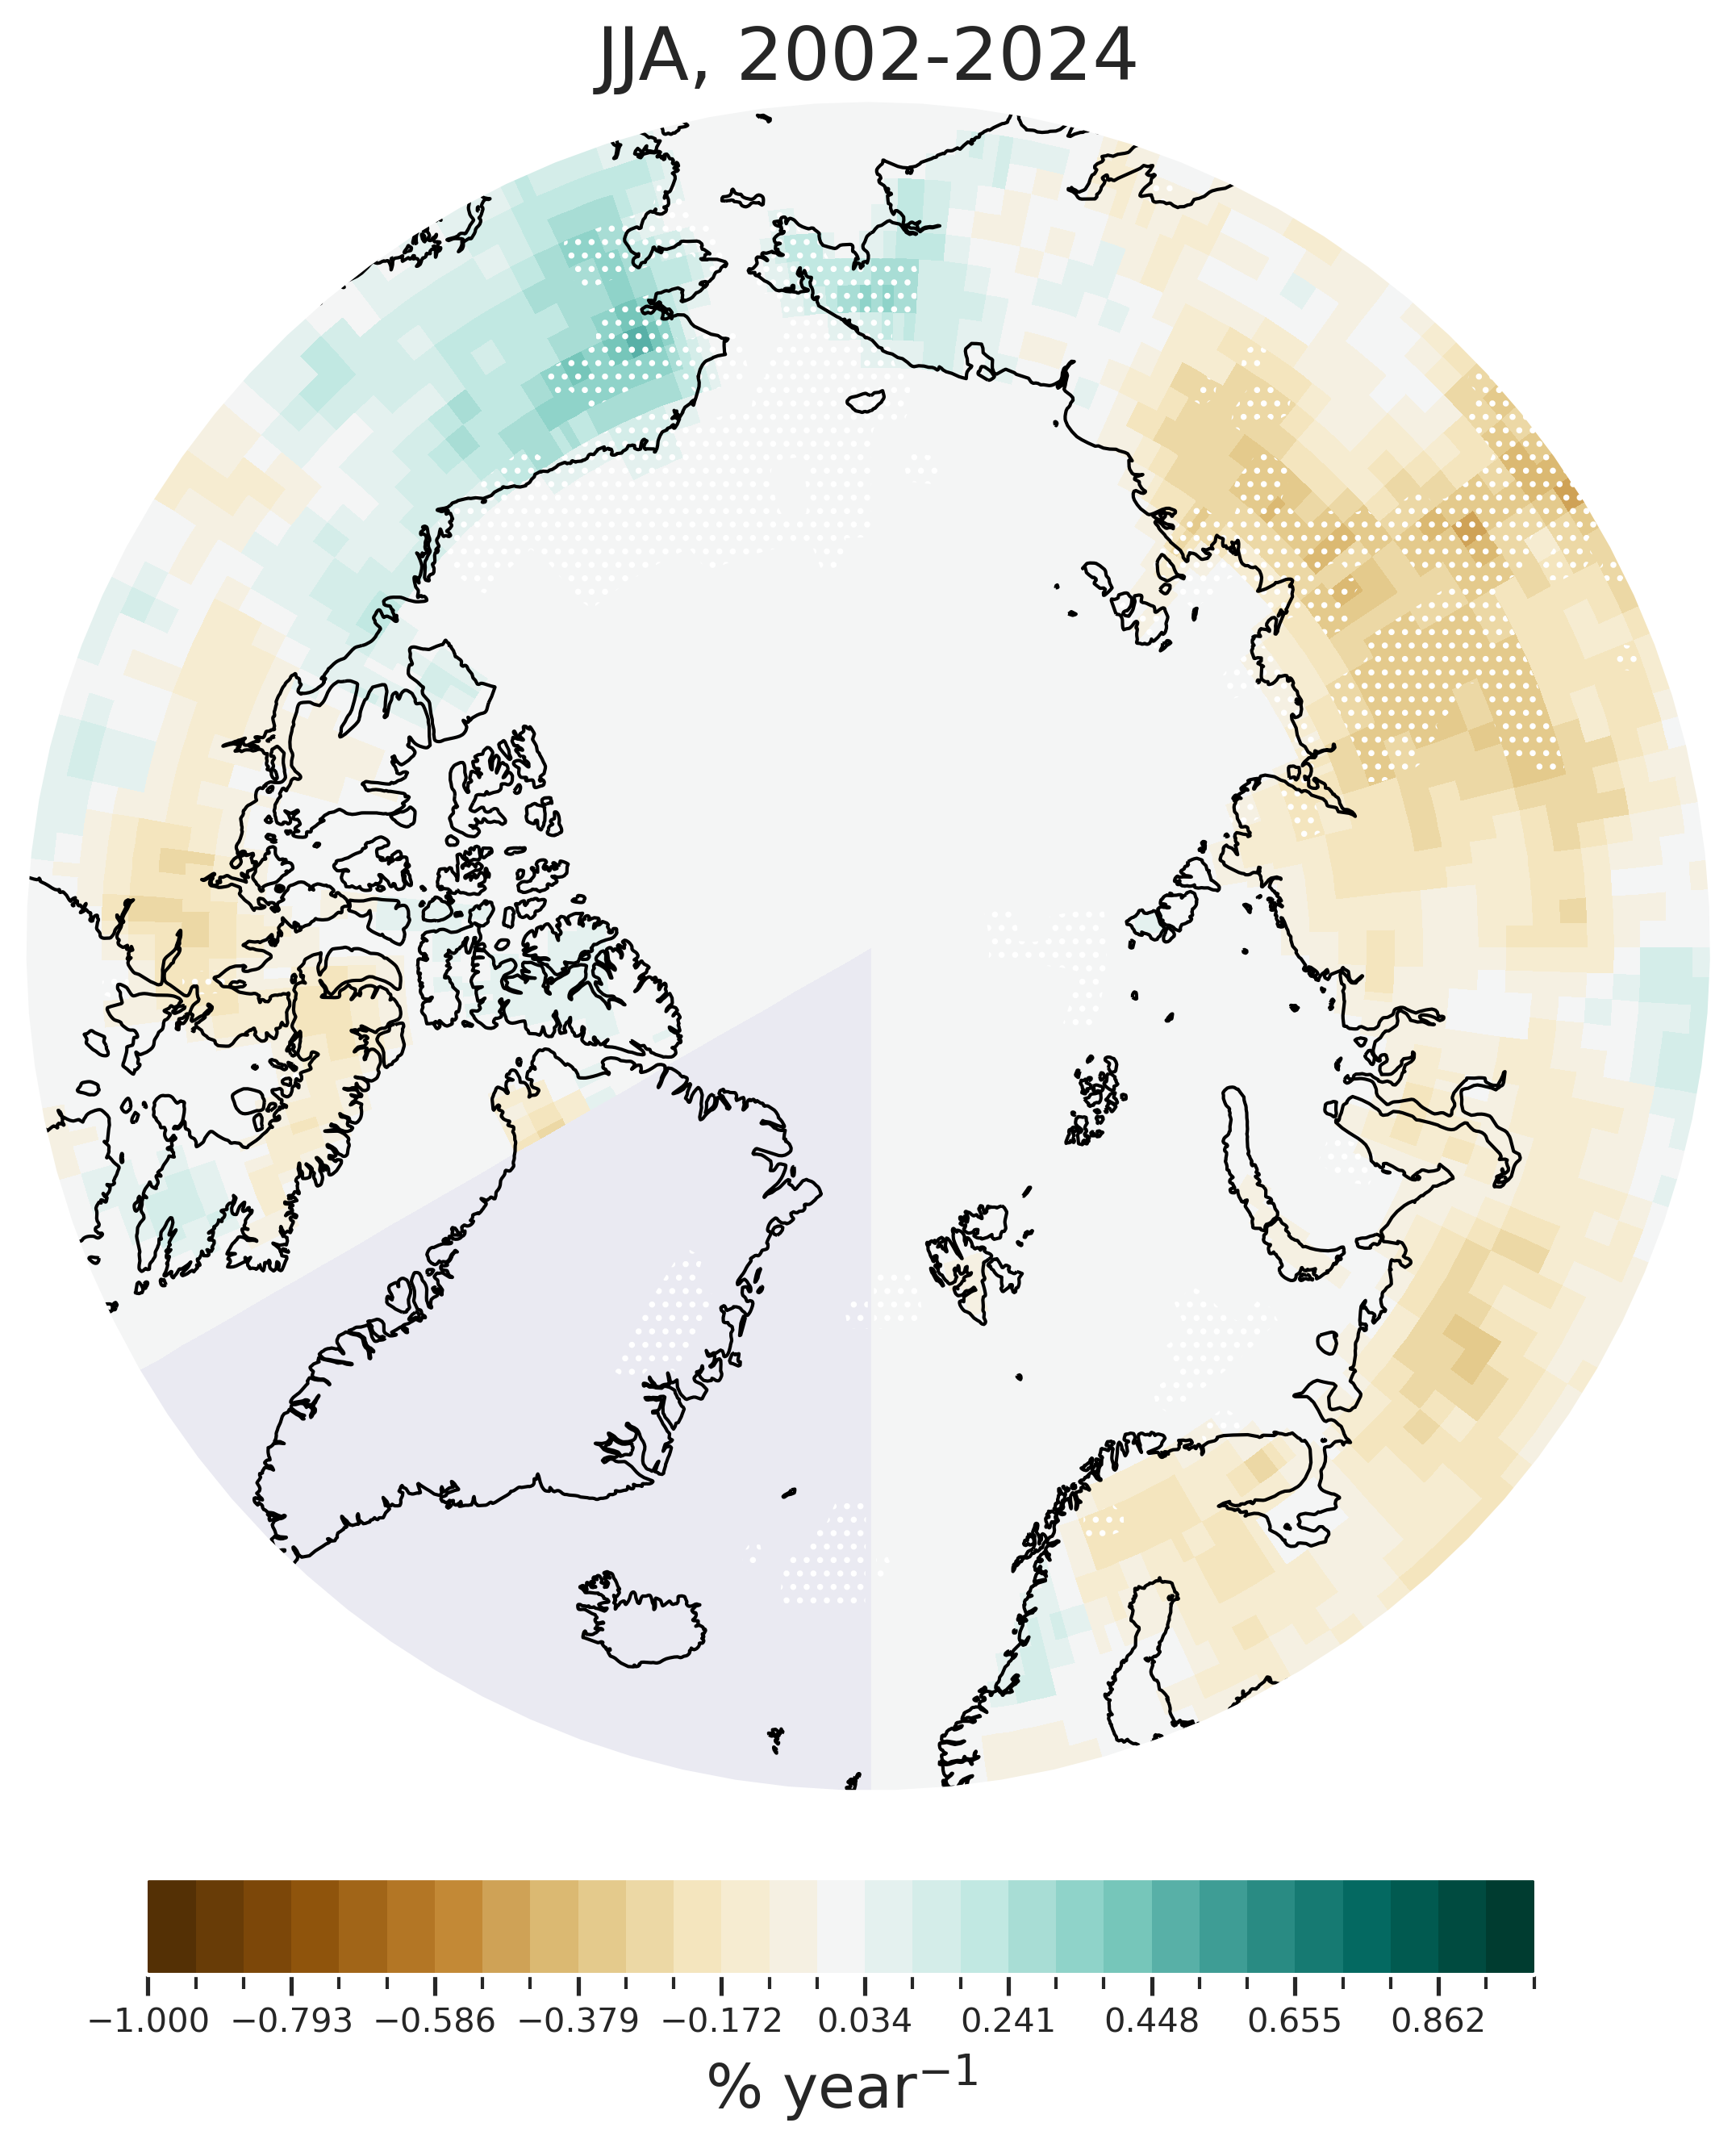

In [141]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'

lim = 1.0
levels = np.linspace(-lim, lim, 30)
significance_level=0.05
density = 3

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ds = ds_annual
for ax,season in zip([ax1], ["JJA"]):

    functions.polarCentral_set_latlim([60,90], ax)
    ds = xr.open_dataset(rpath+"CERES_trends_"+season+".nc")
    #ds = ds.reindex(lat=list(reversed(ds.lat)))
    data = ds['trend'].T
    data = data.sel(lat=slice(60,90),lon=slice(0,300))*landmask_CERES.sel(lat=slice(60,90),lon=slice(0,300))
    data = data.sel(lat=slice(0,90),lon=slice(0,300))*landmask_CERES.sel(lat=slice(0,90),lon=slice(0,300))
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    hatch = ax.contourf(ds.lon, ds.lat, ds['p_value'].T < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[density*'.', density*'.'])
    #hatch.set_edgecolor('white')
    #hatch._hatch_color = (1, 1, 1, 1.0)
    ax.set_title(season+", 2002-2024", fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_xlabel('% year$^{-1}$', fontsize=18)

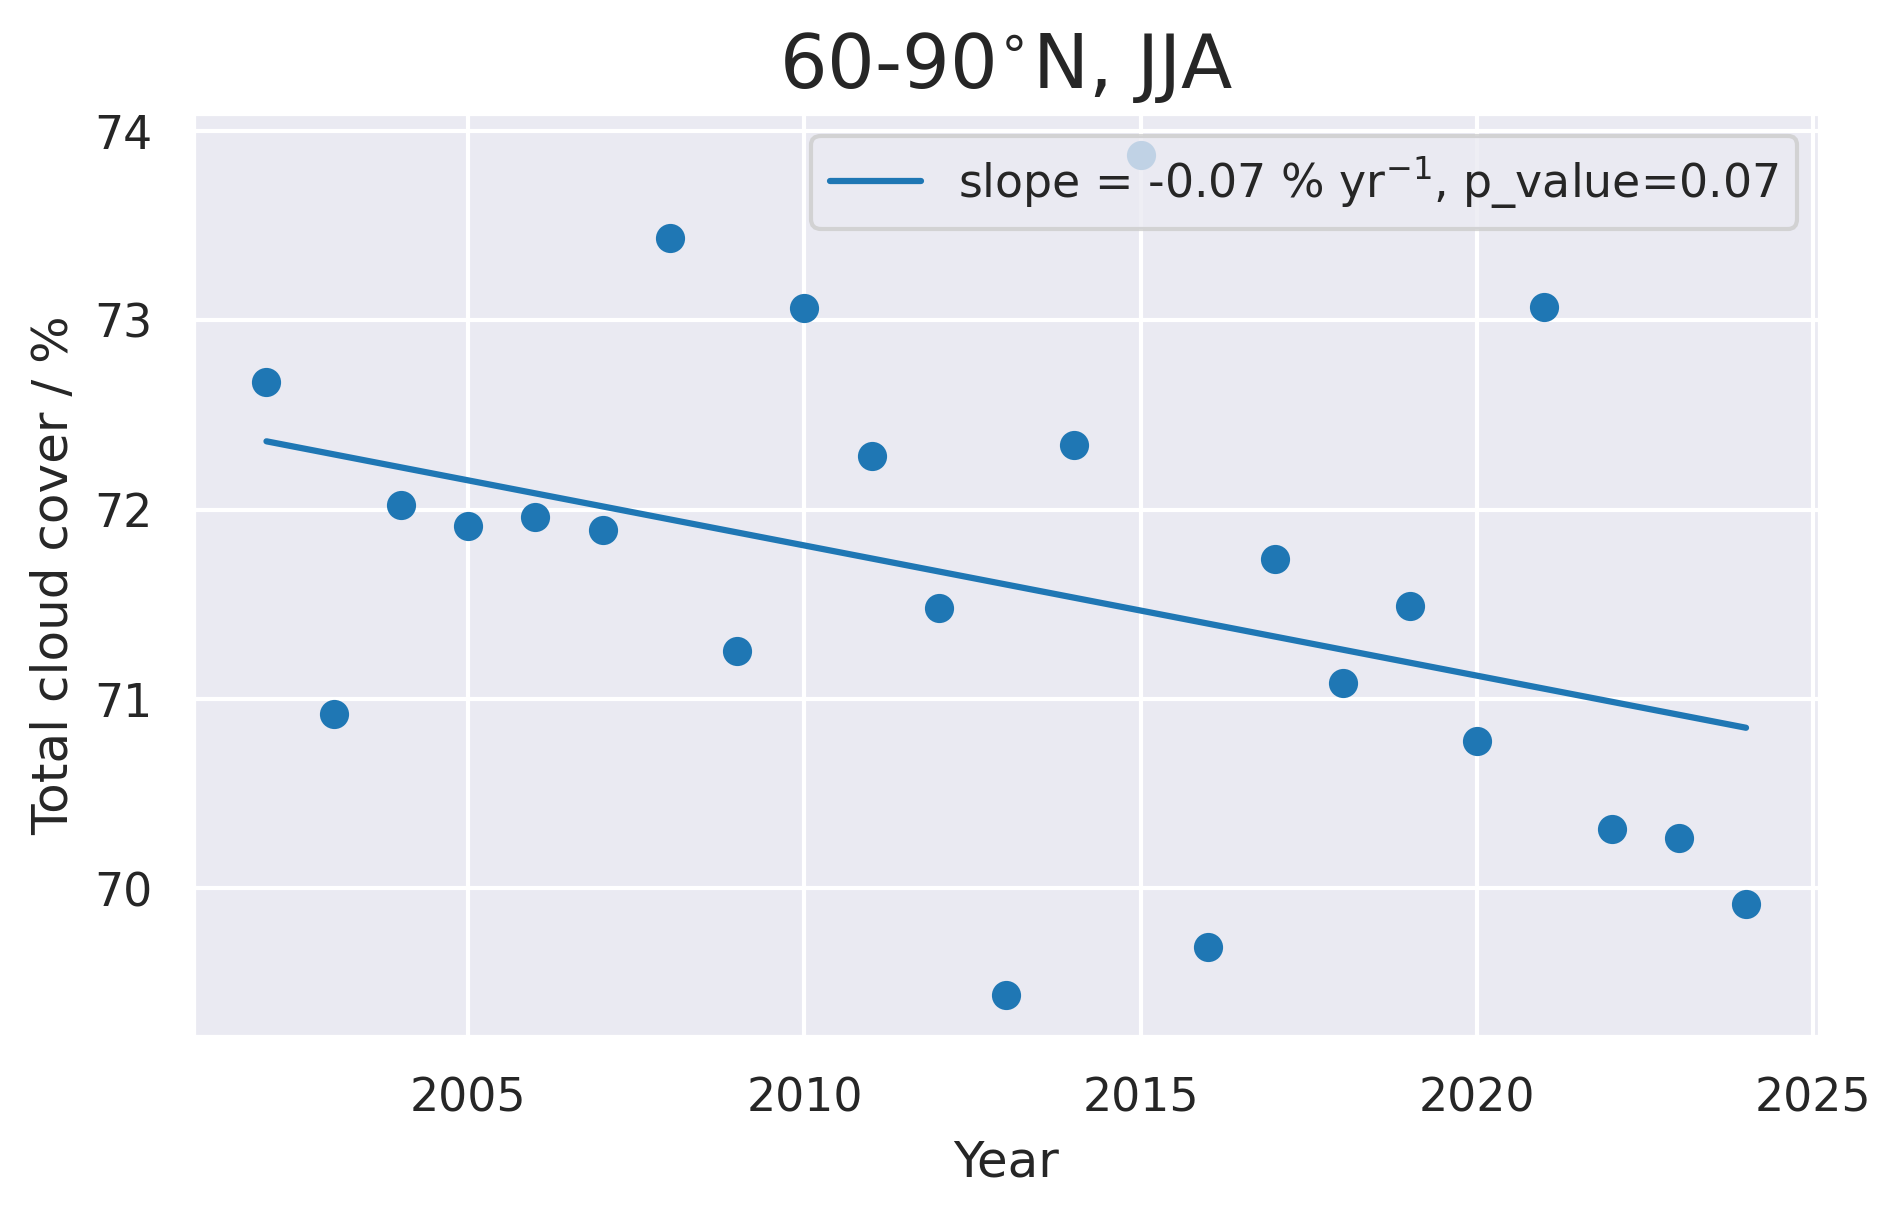

In [144]:
import seaborn as sns
from scipy import stats
sns.set_theme()

Arctic_limit=60
season = 'JJA'

# Seasonal averages
CERES_Arctic = functions.computeWeightedMeanMasked(CERES['cldarea_total_daynight_mon'].sel(lat=slice(Arctic_limit, 90),lon=slice(0,300)), landmask_CERES.sel(lat=slice(Arctic_limit, 90),lon=slice(0,300)))
#CERES_Arctic = functions.computeWeightedMeanMasked(CERES['cldarea_total_daynight_mon'].sel(lat=slice(Arctic_limit, 90)), landmask_CERES.sel(lat=slice(Arctic_limit, 90)))
ds_season = CERES_Arctic.sel(time=CERES_Arctic.time.dt.season==season)
ds_annual = ds_season.groupby(ds_season.time.dt.year).mean('time')
#ds_annual = ds_annual.sel(year=slice(2003,2023))

plt.figure(figsize=(7, 4), dpi=300)

for i in range(0, len(ds_annual.year)):
    plt.scatter(ds_annual.year[i], ds_annual.isel(year=i), color='tab:blue')

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year, ds_annual.values)
plt.plot(ds_annual.year, intercept+slope*ds_annual.year, color='tab:blue',
         label='slope = '+str(np.round(slope,2))+' % yr$^{-1}$, p_value='+str(np.round(p_value,2)))

#plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Total cloud cover / %')
plt.title(str(Arctic_limit)+'-90$^{\circ}$N, '+season, fontsize=18)
plt.show()

In [ ]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year, converted_ds_annual.isel(longitude=ilon, latitude=ilat))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+".nc")

In [158]:
# Make a spatial average
Arctic_lim = 60
var = 'swvl1'
season = 'JJA'

# Choose area

SM_Arctic = functions.computeWeightedMean_ERA5_Land(SM_ERA5)

<xarray.Dataset> Size: 376B
Dimensions:  (year: 23)
Coordinates:
    number   int64 8B 0
  * year     (year) int64 184B 2002 2003 2004 2005 2006 ... 2021 2022 2023 2024
Data variables:
    swvl1    (year) float64 184B 0.3234 0.3186 0.322 ... 0.3091 0.309 0.3085
-0.03567700893631423
0.010420364131261574


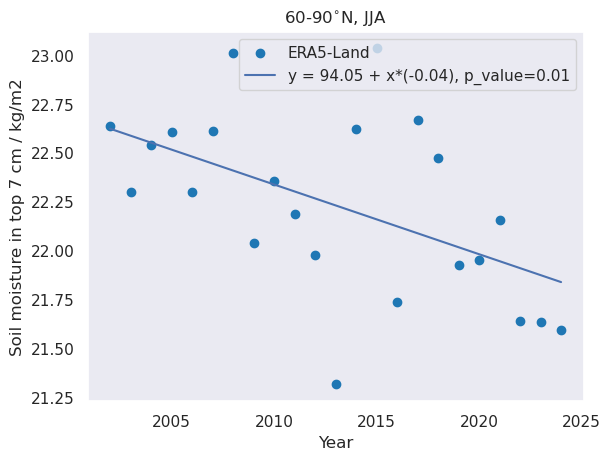

In [159]:
season = 'JJA'
var = 'swvl1'

# Seasonal averages
ds_season = SM_Arctic.sel(valid_time=SM_Arctic.valid_time.dt.season==season)
ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
ds_annual = ds_annual.sel(year=slice(2002,2024))
print(ds_annual)

plt.scatter(ds_annual.year[0], ds_annual[var].isel(year=0)*70, color='tab:blue', label='ERA5-Land')

for i in range(1, len(ds_annual.year)):
    plt.scatter(ds_annual.year[i], ds_annual[var].isel(year=i)*70, color='tab:blue')

from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year, ds_annual[var].values*70)
plt.plot(ds_annual.year, intercept+slope*ds_annual.year, 
         label='y = '+str(np.round(intercept,2))+' + x*('+str(np.round(slope,2))+'), p_value='+str(np.round(p_value,2)))
print(slope)
print(p_value)
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Soil moisture in top 7 cm / kg/m2')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.show()

In [70]:
var = 'swvl1'
ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

In [ ]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year, converted_ds_annual.isel(longitude=ilon, latitude=ilat))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+".nc")


In [75]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year.sel(year=slice(2002,2024)), converted_ds_annual.isel(longitude=ilon, latitude=ilat).sel(year=slice(2002,2024)))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+"_2002_2024.nc")


In [25]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"
var='swvl1'

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = SM_ERA5.sel(valid_time=SM_ERA5.valid_time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.valid_time.dt.year).mean('valid_time')
    converted_ds_annual = ds_annual[var]*70 # from m3/m3 to kg/m2

    trends = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    p_values = np.ones((len(SM_ERA5.longitude),len(SM_ERA5.latitude)))*np.nan
    for ilon in range(len(SM_ERA5.longitude)):
        for ilat in range(len(SM_ERA5.latitude)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(converted_ds_annual.year.sel(year=slice(1970,2016)), converted_ds_annual.isel(longitude=ilon, latitude=ilat).sel(year=slice(1970,2016)))
            trends[ilon, ilat] = slope
            p_values[ilon, ilat] = p_value
    
    ds_annual['trend'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, trends)
    ds_annual['p_value'] = ({'longitude':SM_ERA5.longitude, 'latitude':SM_ERA5.latitude}, p_values)

    ds_annual.to_netcdf(savedir+"SM_ERA5_trends_"+season+"_1970_2016.nc")


In [4]:
season="JJA"
rpath = "/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"
ds_annual = xr.open_dataset(rpath+"SM_ERA5_trends_"+season+".nc")
ds_annual = ds_annual.reindex(latitude=list(reversed(ds_annual.latitude)))

Text(0.5, 0, 'kg m$^{-2}$ year$^{-1}$')

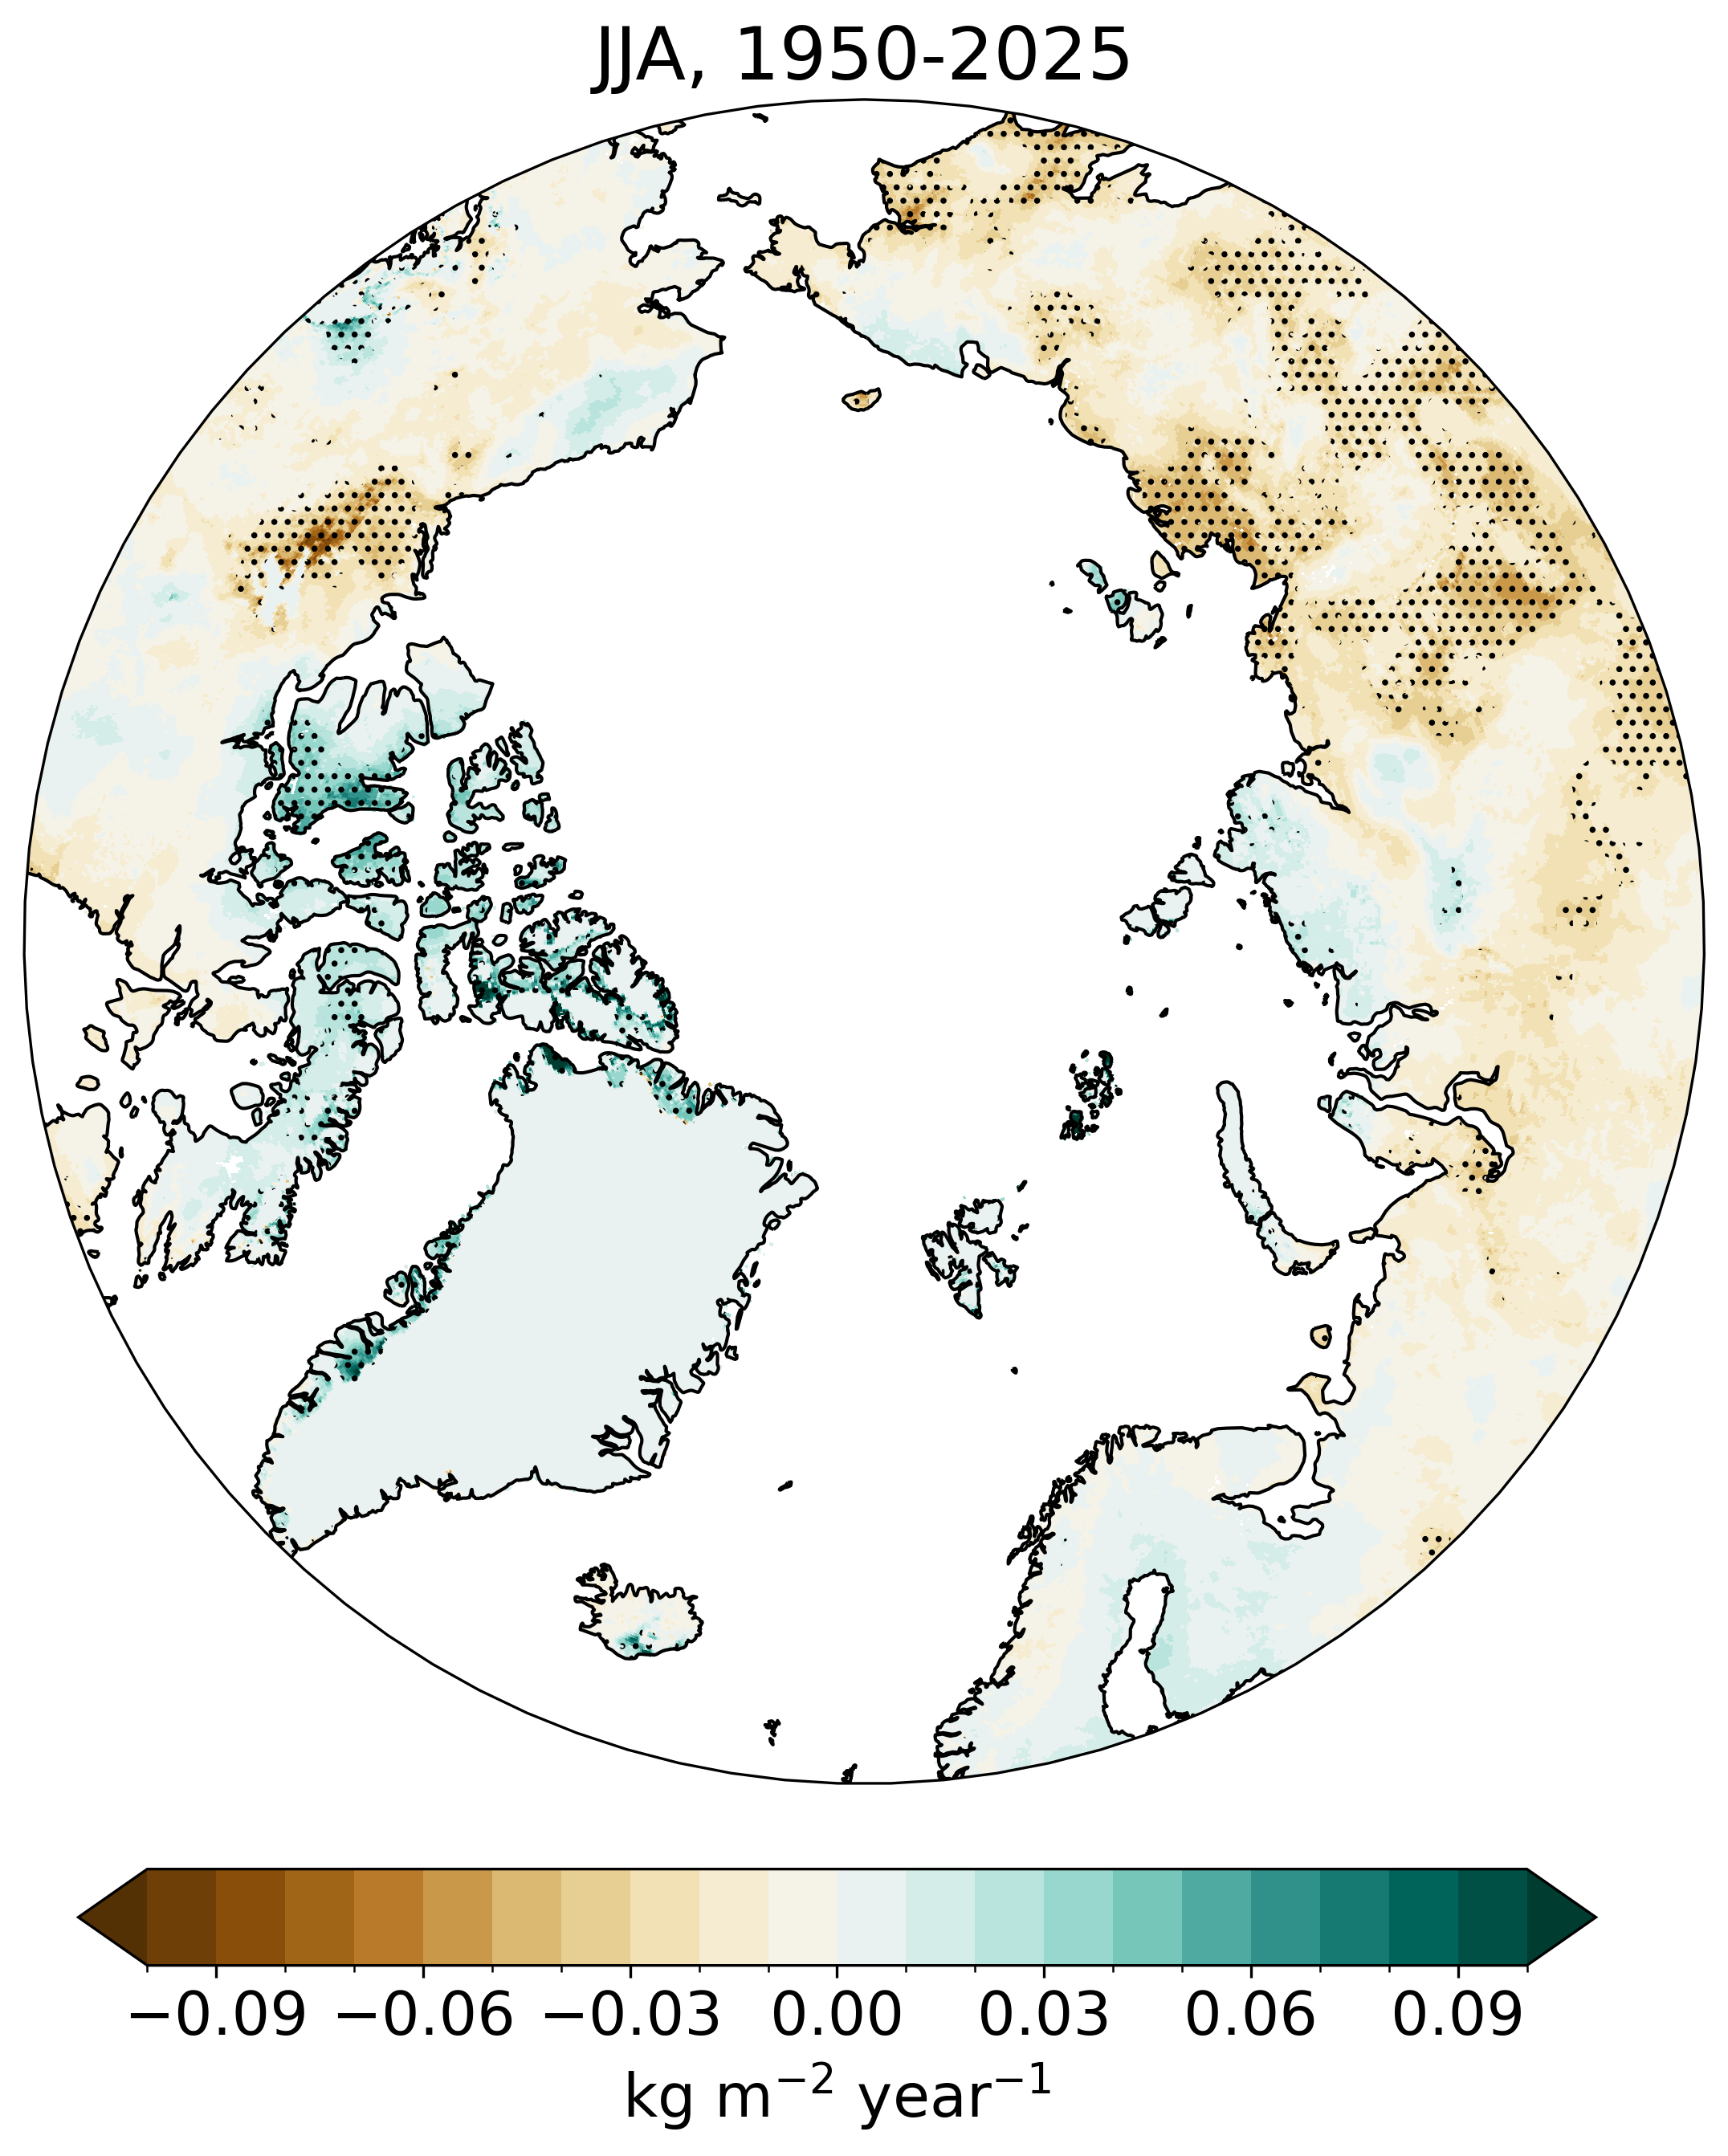

In [ ]:
rpath = "/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"


lim = 0.1
levels = np.linspace(-lim, lim, 21)
significance_level=0.05
density = 3

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

for ax,season in zip([ax1], ["JJA"]):

    functions.polarCentral_set_latlim([60,90], ax)
    ds = xr.open_dataset(rpath+"SM_ERA5_trends_"+season+".nc")
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    data = ds['trend'].T
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    hatch = ax.contourf(ds.longitude, ds.latitude, ds['p_value'].T < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[density*'.', density*'.'])
    #hatch.set_edgecolor('white')
    #hatch._hatch_color = (1, 1, 1, 1.0)
    ax.set_title(season+", 1950-2025", fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel('kg m$^{-2}$ year$^{-1}$', fontsize=18)

In [ ]:
import seaborn as sns
from scipy import stats
sns.set_theme()

season = 'JJA'

# Seasonal averages
CERES_Arctic = CERES['cldarea']
ds_season_WM = SM_Arctic_WM.sel(time=SM_Arctic_WM.time.dt.season==season)
ds_annual_WM = ds_season_WM.groupby(ds_season_WM.time.dt.year).mean('time')

plt.figure(figsize=(7, 4), dpi=300)

plt.scatter(ds_annual_ERA.year[0], ds_annual_ERA['swvl1'].isel(year=0)*70, color='tab:blue', label='ERA5-Land, top 7 cm')
plt.scatter(ds_annual_WM.year[0], ds_annual_WM['mrsos'].isel(year=0), color='tab:orange', label='Wang & Mao (2021), top 10 cm')

for i in range(1, len(ds_annual_ERA.year)):
    plt.scatter(ds_annual_ERA.year[i], ds_annual_ERA['swvl1'].isel(year=i)*70, color='tab:blue')

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_ERA.year, ds_annual_ERA['swvl1'].values*70)
plt.plot(ds_annual_ERA.year, intercept+slope*ds_annual_ERA.year, color='tab:blue',
         label='slope = '+str(np.round(slope,2))+' kg m$^{-2}$ yr$^{-1}$, p_value='+str(np.round(p_value,2)))


for i in range(1, len(ds_annual_WM.year)):
    plt.scatter(ds_annual_WM.year[i], ds_annual_WM['mrsos'].isel(year=i), color='tab:orange')

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_WM.year, ds_annual_WM['mrsos'].values)
plt.plot(ds_annual_WM.year, intercept+slope*ds_annual_WM.year, color='tab:orange',
         label='slope = '+str(np.round(slope,2))+' kg m$^{-2}$ yr$^{-1}$, p_value='+str(np.round(p_value,2)))
#plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Surface soil moisture / kg m$^{-2}$')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season, fontsize=18)
plt.show()

Text(0.5, 0, 'kg m$^{-2}$ year$^{-1}$')

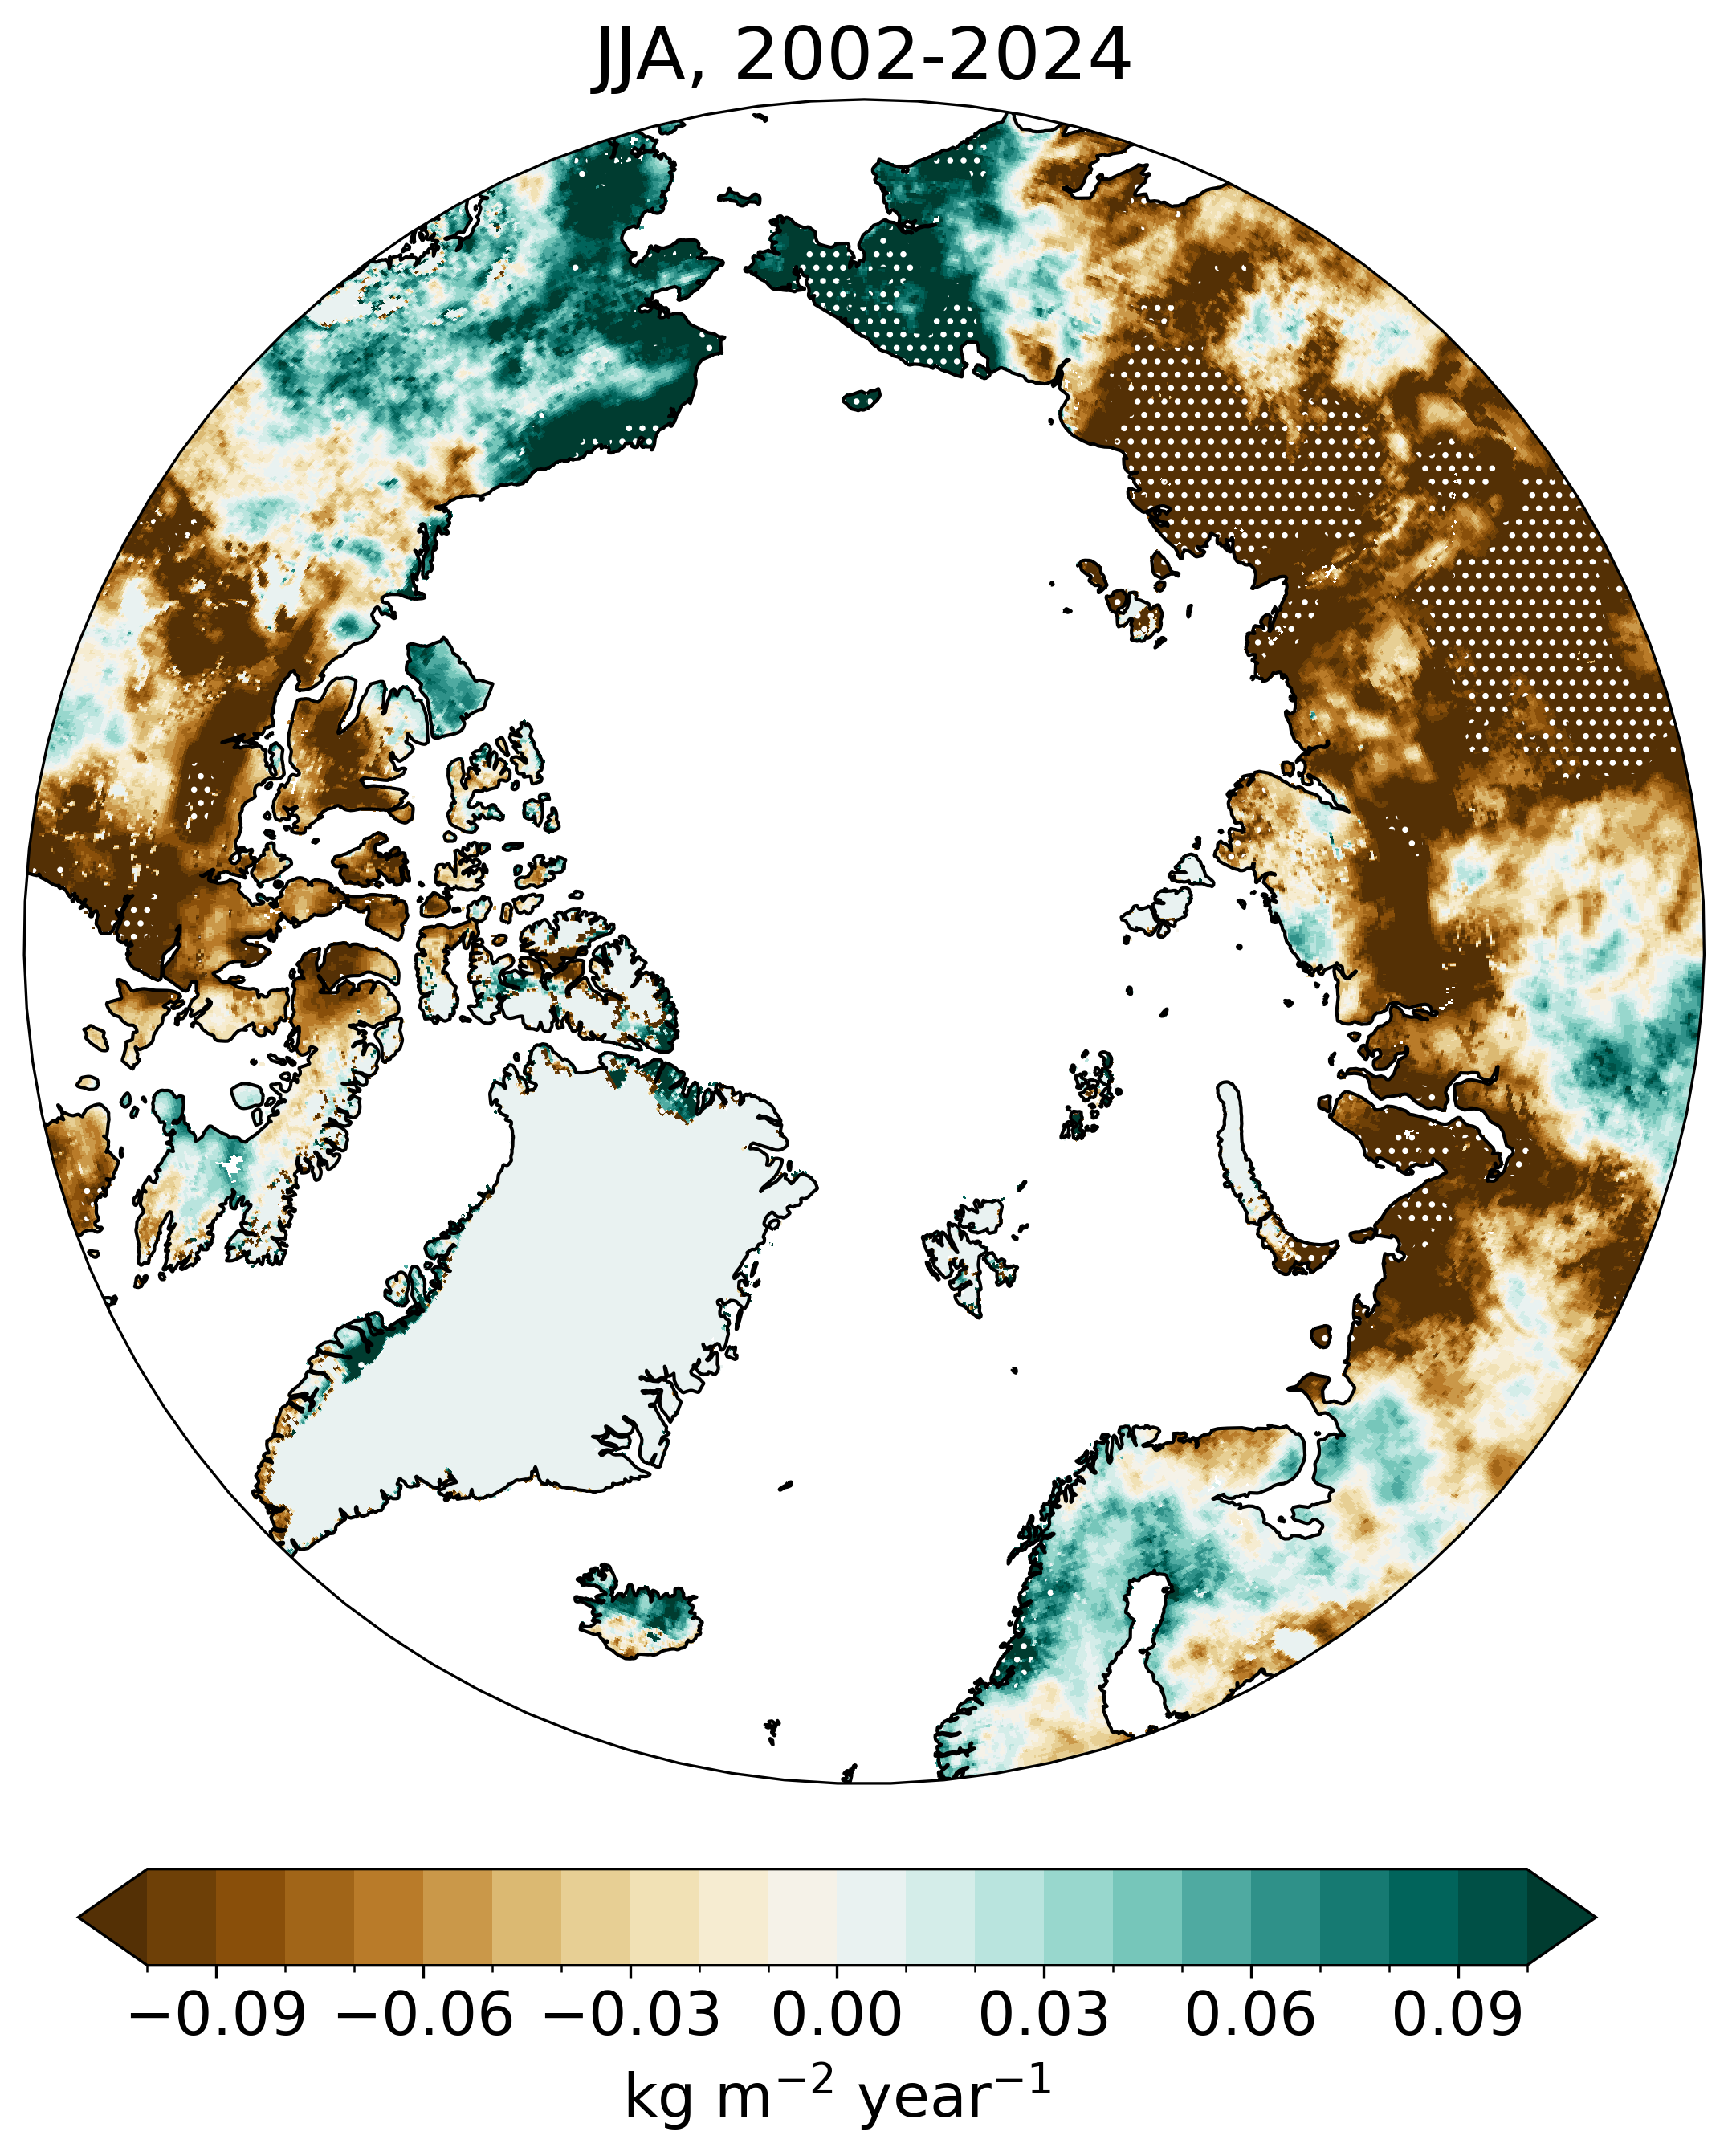

In [6]:
lim = 0.1
levels = np.linspace(-lim, lim, 21)
significance_level=0.05
density = 3

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
#ax1 = plt.subplot(2, 2, 1, projection=ccrs.Orthographic(0, 90))
#ax2 = plt.subplot(2, 2, 2, projection=ccrs.Orthographic(0, 90))
#ax3 = plt.subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
#ax4 = plt.subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))

#for ax,season,label in zip([ax1, ax2, ax3, ax4], ["DJF", "MAM","JJA","SON"], ["(a)", "(b)", "(c)", "(d)"]):
for ax,season in zip([ax1], ["JJA"]):

    functions.polarCentral_set_latlim([60,90], ax)
    ds = xr.open_dataset(rpath+"SM_ERA5_trends_"+season+"_2002_2024.nc")
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    data = ds['trend'].T
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    hatch = ax.contourf(ds.longitude, ds.latitude, ds['p_value'].T < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[density*'.',density*'.'])
    #hatch.set_edgecolor('white')
    hatch._hatch_color = (1, 1, 1, 1.0)
    ax.set_title(season+", 2002-2024", fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel('kg m$^{-2}$ year$^{-1}$', fontsize=18)

Text(0.5, 0, 'kg m$^{-2}$ year$^{-1}$')

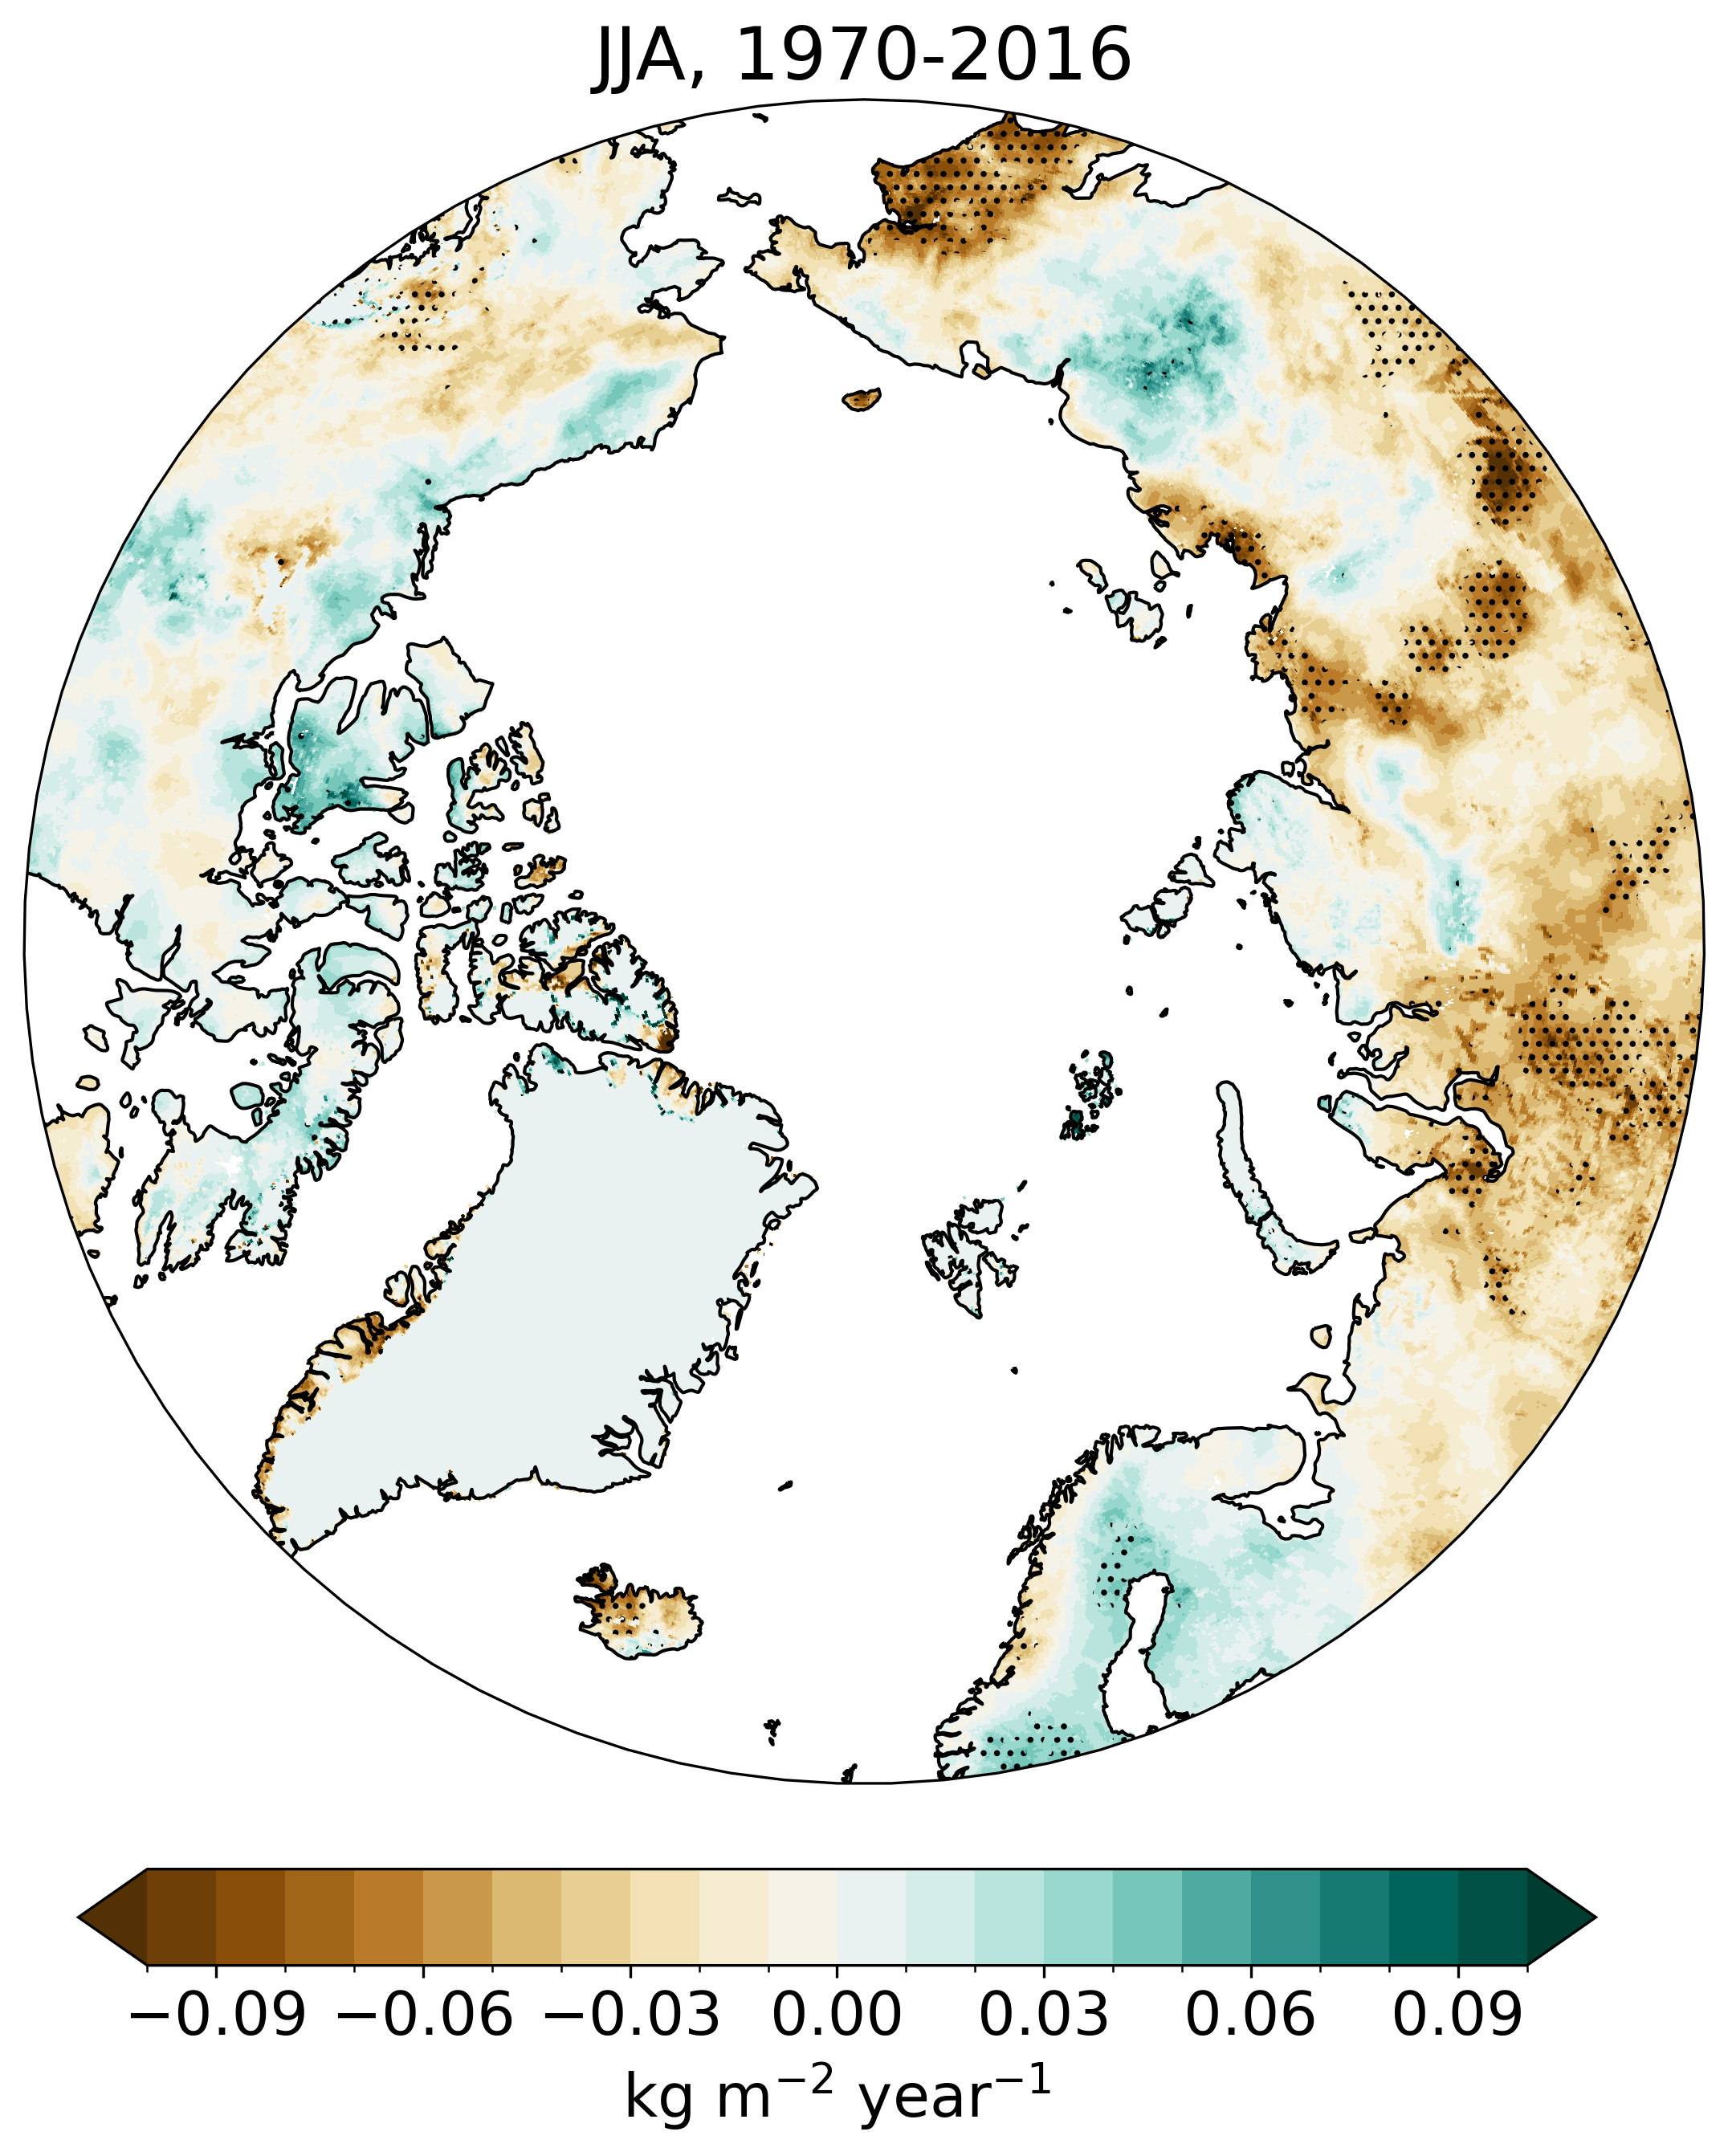

In [29]:
lim = 0.1
levels = np.linspace(-lim, lim, 21)
significance_level=0.05
density = 3
season="JJA"
rpath="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
#ax1 = plt.subplot(2, 2, 1, projection=ccrs.Orthographic(0, 90))
#ax2 = plt.subplot(2, 2, 2, projection=ccrs.Orthographic(0, 90))
#ax3 = plt.subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
#ax4 = plt.subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))

#for ax,season,label in zip([ax1, ax2, ax3, ax4], ["DJF", "MAM","JJA","SON"], ["(a)", "(b)", "(c)", "(d)"]):
for ax,season in zip([ax1], ["JJA"]):

    functions.polarCentral_set_latlim([60,90], ax)
    ds = xr.open_dataset(rpath+"SM_ERA5_trends_"+season+"_1970_2016.nc")
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    data = ds['trend'].T
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    hatch = ax.contourf(ds.longitude, ds.latitude, ds['p_value'].T < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[density*'.',density*'.'])
    #hatch.set_edgecolor('white')
    #hatch._hatch_color = (1, 1, 1, 1.0)
    ax.set_title(season+", 1970-2016", fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel('kg m$^{-2}$ year$^{-1}$', fontsize=18)

In [4]:
filepath='/nird/datalake/NS9560K/diagnostics/ILAMB-Data/DATA/mrsos/WangMao/mrsos_olc.nc'
ds_SM_WM = xr.open_dataset(filepath)

In [11]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = ds_SM_WM.sel(time=ds_SM_WM.time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.time.dt.year).mean('time')

    trends = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    p_values = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    for ilat in range(len(ds_SM_WM.lat)):
        for ilon in range(len(ds_SM_WM.lon)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year, ds_annual['mrsos'].isel(lat=ilat, lon=ilon))
            trends[ilat, ilon] = slope
            p_values[ilat, ilon] = p_value
    
    ds_annual['trend'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, trends)
    ds_annual['p_value'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, p_values)

    ds_annual.to_netcdf(savedir+"SM_WM_trends_"+season+".nc")

In [19]:
from scipy import stats
savedir="/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"

#for season in ["DJF", "MAM","JJA","SON"]:
for season in ["JJA"]:
    ds_season = ds_SM_WM.sel(time=ds_SM_WM.time.dt.season==season)
    ds_annual = ds_season.groupby(ds_season.time.dt.year).mean('time')

    trends = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    p_values = np.ones((len(ds_SM_WM.lat),len(ds_SM_WM.lon)))*np.nan
    for ilat in range(len(ds_SM_WM.lat)):
        for ilon in range(len(ds_SM_WM.lon)):
            slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual.year.sel(year=slice(1994,2016)), ds_annual['mrsos'].isel(lat=ilat, lon=ilon).sel(year=slice(1994,2016)))
            trends[ilat, ilon] = slope
            p_values[ilat, ilon] = p_value
    
    ds_annual['trend'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, trends)
    ds_annual['p_value'] = ({'lat':ds_SM_WM.lat, 'lon':ds_SM_WM.lon}, p_values)

    ds_annual.to_netcdf(savedir+"SM_WM_trends_"+season+"_1994_2016.nc")

Text(0.5, 0, 'kg m$^{-2}$ year$^{-1}$')

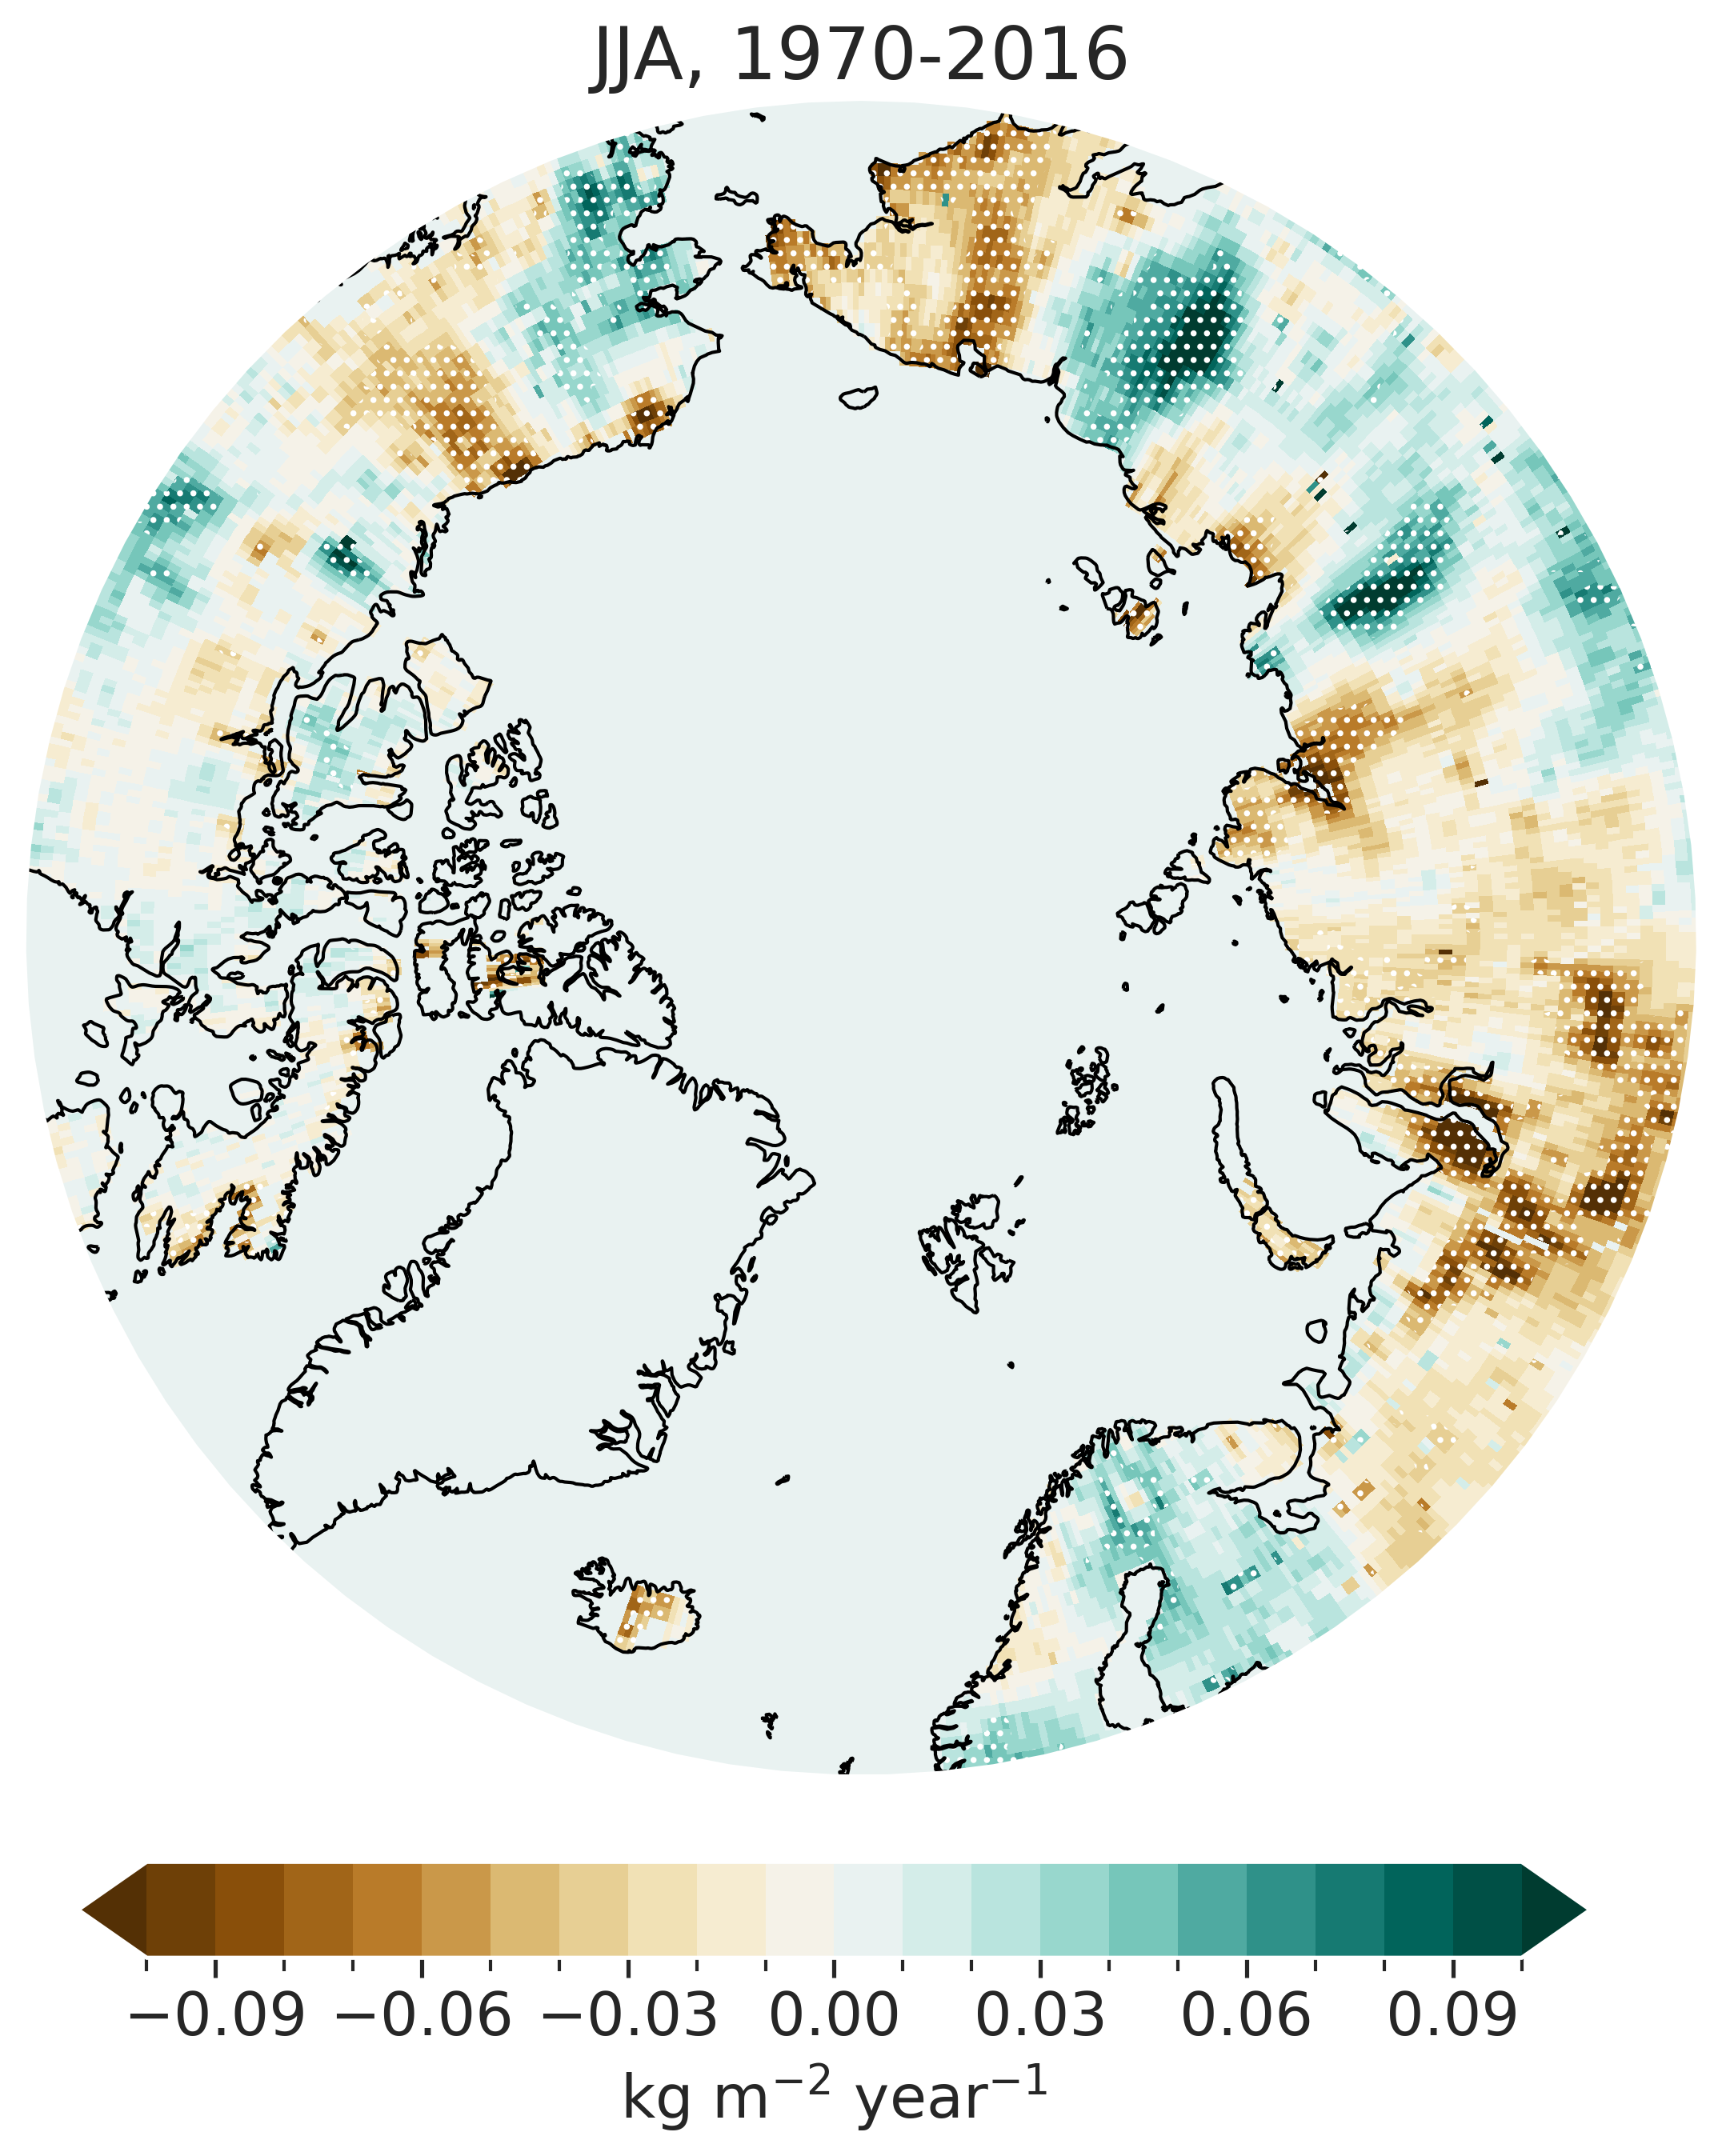

In [161]:
rpath = "/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"


lim = 0.1
levels = np.linspace(-lim, lim, 21)
significance_level=0.05
density = 3

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
#ax1 = plt.subplot(2, 2, 1, projection=ccrs.Orthographic(0, 90))
#ax2 = plt.subplot(2, 2, 2, projection=ccrs.Orthographic(0, 90))
#ax3 = plt.subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
#ax4 = plt.subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))

#for ax,season,label in zip([ax1, ax2, ax3, ax4], ["DJF", "MAM","JJA","SON"], ["(a)", "(b)", "(c)", "(d)"]):
for ax,season in zip([ax1], ["JJA"]):

    functions.polarCentral_set_latlim([60,90], ax)
    ds = xr.open_dataset(rpath+"SM_WM_trends_"+season+".nc")
    data = ds['trend']
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    hatch = ax.contourf(ds.lon, ds.lat, ds['p_value'] < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[density*'.', density*'.'])
    #hatch.set_edgecolor('white')
    #hatch._hatch_color = (1, 1, 1, 1.0)
    ax.set_title(season+", 1970-2016", fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel('kg m$^{-2}$ year$^{-1}$', fontsize=18)

Text(0.5, 0, 'kg m$^{-2}$ year$^{-1}$')

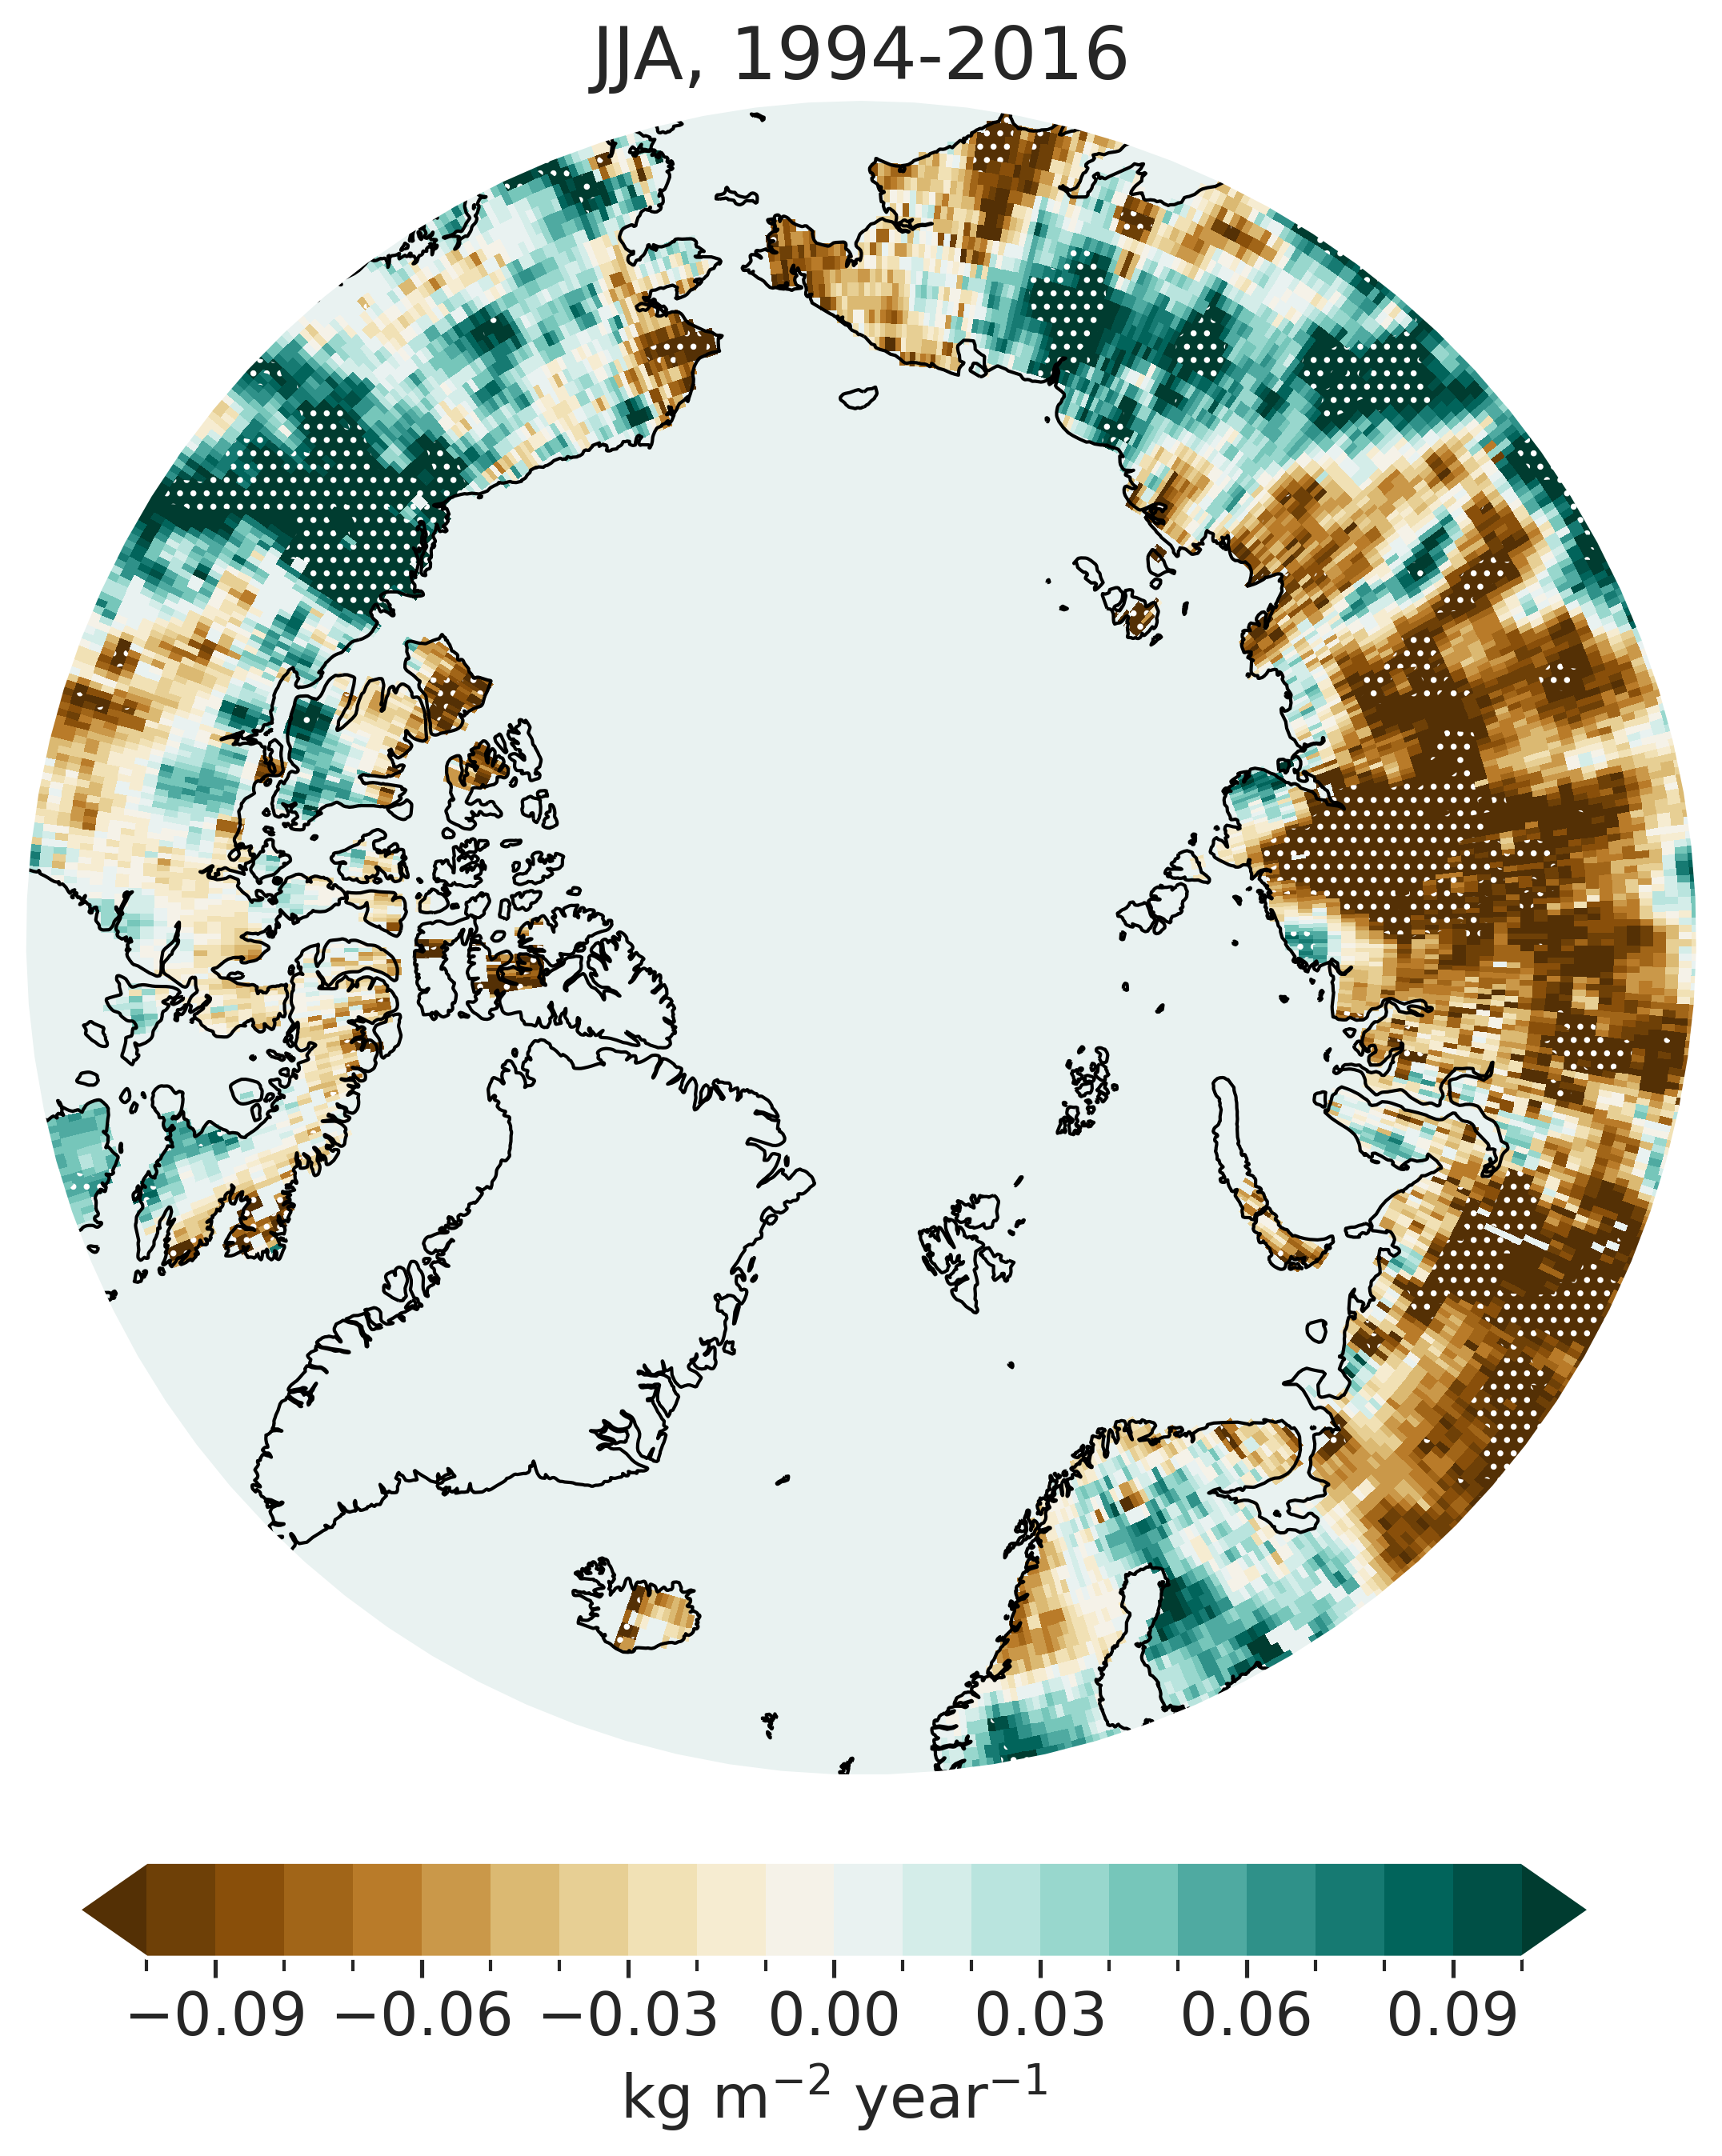

In [162]:
rpath = "/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/soil_moisture_ERA5/"


lim = 0.1
levels = np.linspace(-lim, lim, 21)
significance_level=0.05
density = 3

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
#ax1 = plt.subplot(2, 2, 1, projection=ccrs.Orthographic(0, 90))
#ax2 = plt.subplot(2, 2, 2, projection=ccrs.Orthographic(0, 90))
#ax3 = plt.subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
#ax4 = plt.subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))

#for ax,season,label in zip([ax1, ax2, ax3, ax4], ["DJF", "MAM","JJA","SON"], ["(a)", "(b)", "(c)", "(d)"]):
for ax,season in zip([ax1], ["JJA"]):

    functions.polarCentral_set_latlim([60,90], ax)
    ds = xr.open_dataset(rpath+"SM_WM_trends_"+season+"_1994_2016.nc")
    data = ds['trend']
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG', levels=levels,
                                        add_colorbar=False)
    hatch = ax.contourf(ds.lon, ds.lat, ds['p_value'] < significance_level, transform=ccrs.PlateCarree(), colors='none', levels=[.5,1.5], hatches=[density*'.', density*'.'])
    #hatch.set_edgecolor('white')
    hatch._hatch_color = (1, 1, 1, 1.0)
    ax.set_title(season+", 1994-2016", fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel('kg m$^{-2}$ year$^{-1}$', fontsize=18)

In [48]:
# Make a spatial average
Arctic_lim = 60
var = 'swvl1'

# Choose area

SM_Arctic_ERA5 = functions.computeWeightedMean_ERA5_Land(SM_ERA5_1994_2025)

In [8]:
def computeWeightedMean_WM(ds):

    # Author: Anne Fouilloux
    import numpy as np

    # Compute weights based on the xarray you pass
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    # Compute weighted mean
    air_weighted = ds.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"))
    return weighted_mean

In [49]:
# Make a spatial average
Arctic_lim = 60
var = 'mrsos'

# Choose area

#ds_SM_WM = ds_SM_WM.drop_vars('time_bounds')
SM_Arctic_WM = computeWeightedMean_WM(SM_WM.sel(lat=slice(Arctic_lim,90)))

In [50]:
SM_Arctic_WM

<xarray.Dataset> Size: 4kB
Dimensions:  (time: 276)
Coordinates:
  * time     (time) object 2kB 1994-01-16 12:00:00 ... 2016-12-16 12:00:00
Data variables:
    mrsos    (time) float64 2kB 31.49 31.56 31.65 32.55 ... 28.81 30.08 30.91

In [31]:
import seaborn as sns
sns.set_style()

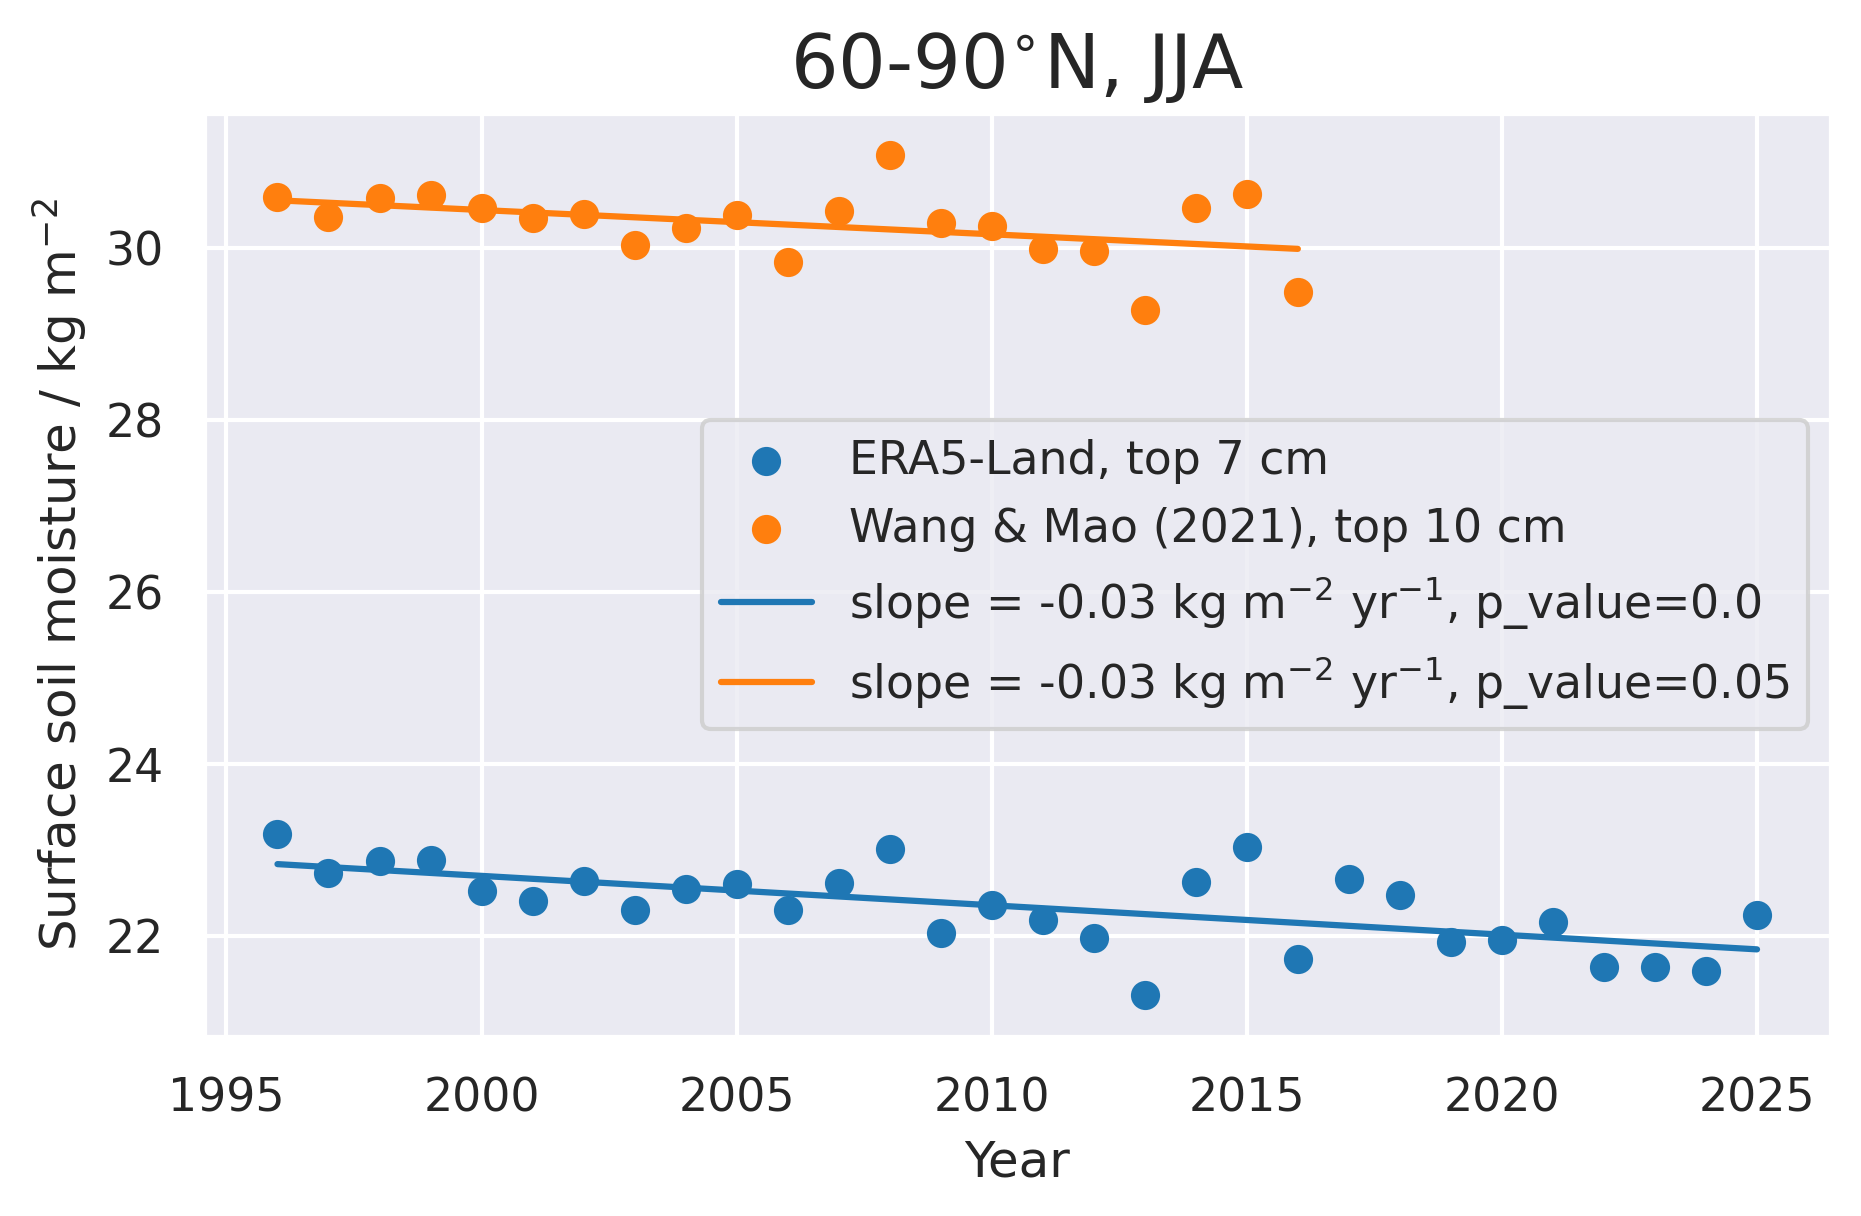

In [54]:
import seaborn as sns
from scipy import stats
sns.set_theme()

season = 'JJA'

# Seasonal averages
ds_season_ERA = SM_Arctic_ERA5.sel(valid_time=SM_Arctic_ERA5.valid_time.dt.season==season)
ds_annual_ERA = ds_season_ERA.groupby(ds_season_ERA.valid_time.dt.year).mean('valid_time')
ds_annual_ERA = ds_annual_ERA.sel(year=slice(1996,2025))


ds_season_WM = SM_Arctic_WM.sel(time=SM_Arctic_WM.time.dt.season==season)
ds_annual_WM = ds_season_WM.groupby(ds_season_WM.time.dt.year).mean('time')
ds_annual_WM = ds_annual_WM.sel(year=slice(1996,2016))

plt.figure(figsize=(7, 4), dpi=300)

plt.scatter(ds_annual_ERA.year[0], ds_annual_ERA['swvl1'].isel(year=0)*70, color='tab:blue', label='ERA5-Land, top 7 cm')
plt.scatter(ds_annual_WM.year[0], ds_annual_WM['mrsos'].isel(year=0), color='tab:orange', label='Wang & Mao (2021), top 10 cm')

for i in range(1, len(ds_annual_ERA.year)):
    plt.scatter(ds_annual_ERA.year[i], ds_annual_ERA['swvl1'].isel(year=i)*70, color='tab:blue')

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_ERA.year, ds_annual_ERA['swvl1'].values*70)
plt.plot(ds_annual_ERA.year, intercept+slope*ds_annual_ERA.year, color='tab:blue',
         label='slope = '+str(np.round(slope,2))+' kg m$^{-2}$ yr$^{-1}$, p_value='+str(np.round(p_value,2)))


for i in range(1, len(ds_annual_WM.year)):
    plt.scatter(ds_annual_WM.year[i], ds_annual_WM['mrsos'].isel(year=i), color='tab:orange')

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_WM.year, ds_annual_WM['mrsos'].values)
plt.plot(ds_annual_WM.year, intercept+slope*ds_annual_WM.year, color='tab:orange',
         label='slope = '+str(np.round(slope,2))+' kg m$^{-2}$ yr$^{-1}$, p_value='+str(np.round(p_value,2)))
#plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Surface soil moisture / kg m$^{-2}$')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season, fontsize=18)
plt.show()

-0.0051168541189914535


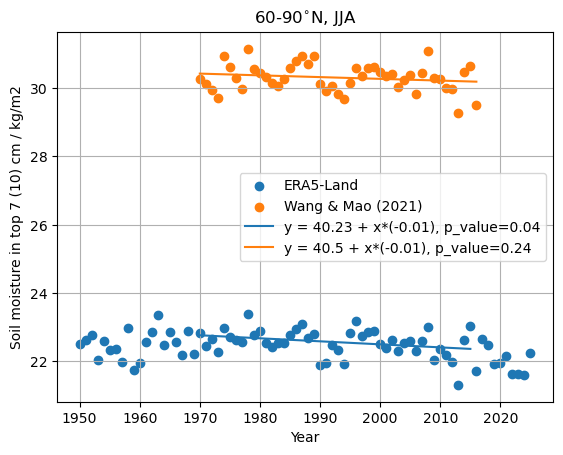

In [20]:
season = 'JJA'

# Seasonal averages
ds_season_ERA = SM_Arctic_ERA5.sel(valid_time=SM_Arctic_ERA5.valid_time.dt.season==season)
ds_annual_ERA = ds_season_ERA.groupby(ds_season_ERA.valid_time.dt.year).mean('valid_time')

ds_season_WM = SM_Arctic_WM.sel(time=SM_Arctic_WM.time.dt.season==season)
ds_annual_WM = ds_season_WM.groupby(ds_season_WM.time.dt.year).mean('time')


plt.scatter(ds_annual_ERA.year[0], ds_annual_ERA['swvl1'].isel(year=0)*70, color='tab:blue', label='ERA5-Land')
plt.scatter(ds_annual_WM.year[0], ds_annual_WM['mrsos'].isel(year=0), color='tab:orange', label='Wang & Mao (2021)')

for i in range(1, len(ds_annual_ERA.year)):
    plt.scatter(ds_annual_ERA.year[i], ds_annual_ERA['swvl1'].isel(year=i)*70, color='tab:blue')

for i in range(1, len(ds_annual_WM.year)):
    plt.scatter(ds_annual_WM.year[i], ds_annual_WM['mrsos'].isel(year=i), color='tab:orange')


from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_ERA.year.sel(year=slice(1970,2015)), ds_annual_ERA['swvl1'].sel(year=slice(1970,2015)).values*70)
plt.plot(ds_annual_ERA.year.sel(year=slice(1970,2015)), intercept+slope*ds_annual_ERA.year.sel(year=slice(1970,2015)), color='tab:blue',
         label='y = '+str(np.round(intercept,2))+' + x*('+str(np.round(slope,2))+'), p_value='+str(np.round(p_value,2)))

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_WM.year, ds_annual_WM['mrsos'].values)
plt.plot(ds_annual_WM.year, intercept+slope*ds_annual_WM.year, color='tab:orange',
         label='y = '+str(np.round(intercept,2))+' + x*('+str(np.round(slope,2))+'), p_value='+str(np.round(p_value,2)))
print(slope)
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Soil moisture in top 7 (10) cm / kg/m2')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.show()

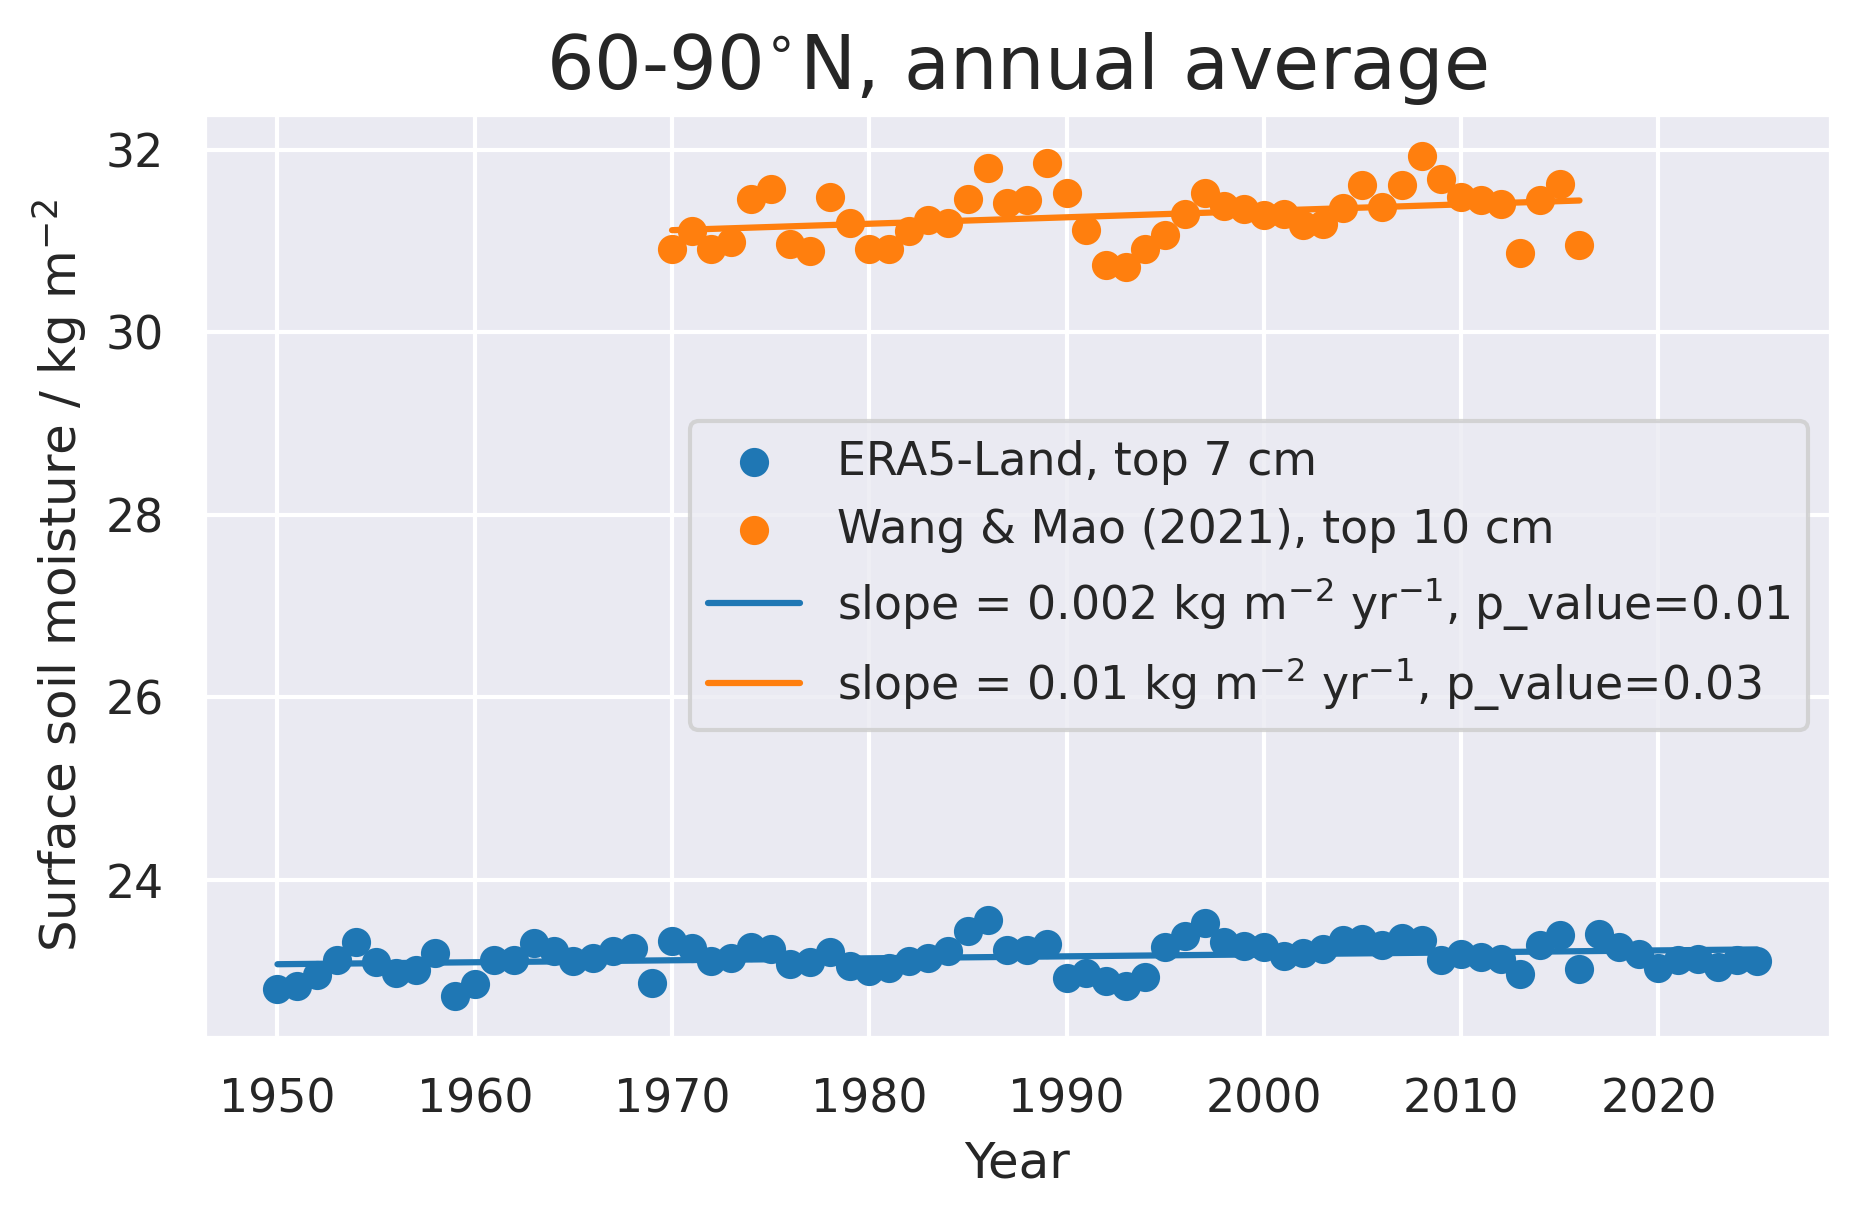

In [51]:
import seaborn as sns
from scipy import stats
sns.set_theme()

season = 'JJA'

# Seasonal averages
ds_annual_ERA = SM_Arctic_ERA5.groupby(SM_Arctic_ERA5.valid_time.dt.year).mean('valid_time')

ds_annual_WM = SM_Arctic_WM.groupby(SM_Arctic_WM.time.dt.year).mean('time')

plt.figure(figsize=(7, 4), dpi=300)

plt.scatter(ds_annual_ERA.year[0], ds_annual_ERA['swvl1'].isel(year=0)*70, color='tab:blue', label='ERA5-Land, top 7 cm')
plt.scatter(ds_annual_WM.year[0], ds_annual_WM['mrsos'].isel(year=0), color='tab:orange', label='Wang & Mao (2021), top 10 cm')

for i in range(1, len(ds_annual_ERA.year)):
    plt.scatter(ds_annual_ERA.year[i], ds_annual_ERA['swvl1'].isel(year=i)*70, color='tab:blue')

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_ERA.year, ds_annual_ERA['swvl1'].values*70)
plt.plot(ds_annual_ERA.year, intercept+slope*ds_annual_ERA.year, color='tab:blue',
         label='slope = '+str(np.round(slope,3))+' kg m$^{-2}$ yr$^{-1}$, p_value='+str(np.round(p_value,2)))


for i in range(1, len(ds_annual_WM.year)):
    plt.scatter(ds_annual_WM.year[i], ds_annual_WM['mrsos'].isel(year=i), color='tab:orange')

slope, intercept, r_value, p_value, std_err = stats.linregress(ds_annual_WM.year, ds_annual_WM['mrsos'].values)
plt.plot(ds_annual_WM.year, intercept+slope*ds_annual_WM.year, color='tab:orange',
         label='slope = '+str(np.round(slope,2))+' kg m$^{-2}$ yr$^{-1}$, p_value='+str(np.round(p_value,2)))
#plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Surface soil moisture / kg m$^{-2}$')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, annual average', fontsize=18)
plt.show()

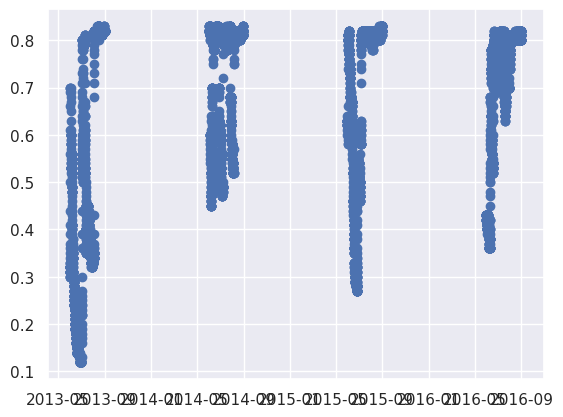

In [156]:
rpath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'
folder = 'ISMN_data_Arctic_1951_2025'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/FMI/SODAWS/FMI_FMI_SODAWS_sm_0.100000_0.100000_ThetaProbe-ML2X-A_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/SCAN/SchorGarden/SCAN_SCAN_SchorGarden_sm_0.254000_0.254000_Hydraprobe-Analog-A_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/FMI/SAA120/FMI_FMI_SAA120_sm_0.050000_0.050000_5TE-B_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/FMI/SOD140/FMI_FMI_SOD140_sm_0.050000_0.050000_CS655-A_19510403_20251212.stm'
filepath = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/ISMN_data_Arctic_1951_2025/SCAN/LowerMulchatna/SCAN_SCAN_LowerMulchatna_sm_0.050800_0.050800_n.s.-A_19510403_20251212.stm'


import pandas as pd
ds = pd.read_csv(filepath,sep=' ',skiprows=1,names=['Date','Time (UTC)','Soil moisture','Flag1','Flag2'],index_col=0)
with open(filepath) as file:
    first_line = file.readline()
first_line = first_line.split(' ')
header = []
for elem in first_line:
    if elem != '':
        header.append(elem)

ds.index = pd.to_datetime(ds.index)
JJA = ds[(ds.index.month > 5) & (ds.index.month < 9)]
plt.scatter(JJA.index, JJA['Soil moisture'])